In [1]:
import os
import sys

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# pcx
import pcx as px
import pcx.predictive_coding as pxc
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

# 3rd party
import jax
from jax import jit
import jax.numpy as jnp
import jax.numpy.linalg as jax_numpy_linalg # for expm()
import jax.scipy.linalg as jax_scipy_linalg # for slogdet()
import jax.random as random
import optax
import numpy as np
import pandas as pd
from pandas.api.types import is_float_dtype
from ucimlrepo import fetch_ucirepo

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import timeit

# own
import causal_helpers
from causal_model import Complete_Graph
from causal_helpers import is_dag_nx, MAE, compute_binary_adjacency, compute_h_reg, notears_dag_constraint, dagma_dag_constraint
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrices
from causal_helpers import load_graph, load_adjacency_matrix
from causal_helpers import plot_weights_distribution, analyze_weight_thresholds
from causal_metrics import compute_F1_directed, compute_F1_skeleton, compute_AUPRC, compute_AUROC, compute_model_fit
from causal_metrics import compute_cycle_F1, compute_cycle_SHD, compute_cycle_KLD, compute_CSS  # CSS: Cyclic Structure Score
from connectome_cyclic_data_generator import sample_cyclic_data

#################### NODAGS #########################

from nodags_flows.models.resblock_trainer import resflow_train_test_wrapper

##################### DGLearn ############################

from dglearn.dglearn.dg.adjacency_structure import AdjacencyStucture
from dglearn.dglearn.dg.graph_equivalence_search import GraphEquivalenceSearch
from dglearn.dglearn.dg.converter import binary2array
from dglearn.dglearn.learning.cyclic_manager import CyclicManager
from dglearn.dglearn.dg.reduction import reduce_support
from dglearn.dglearn.learning.search.virtual import virtual_refine
from dglearn.dglearn.learning.search.tabu import tabu_search

###################### LiNGD #########################

from lingd import LiNGD

##################### FRP ###########################

from frp.run_causal_discovery import  run_filter_rank_prune, run_dglearn

#####################################################

# Set random seed
#seed = 44 # main seed for reproducibility
seed = 11
set_random_seed(seed)

# causal libraries
import cdt, castle
from castle.algorithms import GOLEM, Notears

# causal metrics
from cdt.metrics import precision_recall, SHD, SID
from castle.metrics import MetricsDAG
from castle.common import GraphDAG
from causallearn.graph.SHD import SHD as SHD_causallearn

/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detecting CUDA device(s) : [0]
2025-02-06 16:59:51,454 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-02-06 16:59:51,464 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


CyclicManager is imported from: /home/amine.mcharrak/frp/frp_dglearn/learning/cyclic_manager.py


In [2]:
import os

#   # fetch dataset 
# abalone = fetch_ucirepo(id=1) 
  
# # data (as pandas dataframes) 
# X = abalone.data.features
# y = abalone.data.targets
  
# # metadata 
# #print(abalone.metadata) 

# # now merge X and y to create a single dataframe and give the columns the correct names using abalone.variables.name.values
# df = pd.concat([X, y], axis=1)
# df.columns = abalone.variables.name.values.tolist()
# print(df.head())
# print()
# # show # of unique values in each column
# print(df.nunique())
# # finally convert the Rings variable to a binary variable by setting the threshold to mean(rings)
# df['Rings'] = df['Rings'] > df['Rings'].mean()
# # then convert to integer
# df['Rings'] = df['Rings'].astype(int)
# # also replace the values in Sex with integers
# df['Sex'] = df['Sex'].map({'M': 0, 'F': 1, 'I': 2})

# # now show the first 5 rows of the dataframe
# print(df.head())

# # Create a boolean list for continuous variables (any float dtype)
# is_cont_node = df.dtypes.map(is_float_dtype).tolist()

# # Print the result
# print(is_cont_node)

# # plot the distribution of all variables in the dataframe
# df.hist(figsize=(15, 10))
# plt.show()

#path = '/share/amine.mcharrak/cyclic_data/10ER41_linear_cyclic_GAUSS-EV_seed_2_n_samples_5000/'
#path = '/share/amine.mcharrak/cyclic_data/10ER43_linear_cyclic_GAUSS-EV_seed_3_n_samples_5000/'
path = '/share/amine.mcharrak/cyclic_data/10ER40_linear_cyclic_GAUSS-EV_seed_3_n_samples_5000/'

# Load adjacency matrices, data, and prec_matrix as pandas dataframe
adj_matrix = pd.read_csv(os.path.join(path, 'adj_matrix.csv'), header=None)
data = pd.read_csv(os.path.join(path, 'train.csv'), header=None)
weighted_adj_matrix = pd.read_csv(os.path.join(path, 'W_adj_matrix.csv'), header=None)
prec_matrix = pd.read_csv(os.path.join(path, 'prec_matrix.csv'), header=None)

n_vars = data.shape[1]

B_true = adj_matrix.values
X = data.values
W_true = weighted_adj_matrix.values

# Get edge list from B_true using networkx
G_true = nx.DiGraph(B_true)
edges_list = list(G_true.edges())

# Compute performance metric: SHD
true_graph = AdjacencyStucture(n_vars=n_vars, edge_list=edges_list)
search = GraphEquivalenceSearch(true_graph)
search.search_dfs()

B_true_EC = [binary2array(bstr) for bstr in search.visited_graphs]
print(f"Size of equivalence class of true graph for {path}: {len(B_true_EC)}")

# Check if G_true is cyclic by listing all cycles
print(f"Number of cycles in G_true for {path}: {len(list(nx.simple_cycles(G_true)))}\n")

Size of equivalence class of true graph for /share/amine.mcharrak/cyclic_data/10ER40_linear_cyclic_GAUSS-EV_seed_3_n_samples_5000/: 128
Number of cycles in G_true for /share/amine.mcharrak/cyclic_data/10ER40_linear_cyclic_GAUSS-EV_seed_3_n_samples_5000/: 2



In [3]:
data.head()
# show unique values in each column
print(data.nunique())
# Determine if each variable is continuous or discrete based on the number of unique values
is_cont_node = np.array([True if data[col].nunique() > 2 else False for col in data.columns])
is_cont_node = is_cont_node.tolist()
print(is_cont_node)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64
[True, True, True, True, True, True, True, True, True, True]


In [4]:
# # ## Load the actual connectome data

# # %%
# # load the weighted adjacency matrices for ER and connectome

# # Specify the folder where the adjacency matrices were saved
# folder = '../data/'

# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_cyclic = '/home/amine.mcharrak/connectome/data/'
# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_acyclic = '/home/amine.mcharrak/connectome/data/'

# # Example usage to load the saved adjacency matrices
# # G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
# # G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
# # ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
# # ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# # Change name of the connectome adjacency matrix to C and C_dag
# # C = G_A_init_t_ordered_adj_matrix
# # C_dag = G_A_init_t_ordered_dag_adj_matrix

# # Now ensure that both DAG adjacency matrices are binary, if they aren't already
# # ER_dag_bin = (ER_dag != 0).astype(int)
# # C_dag_bin = (C_dag != 0).astype(int)

# # ER_true = ER_dag_bin
# # C_true = C_dag_bin

# # %% [markdown]
# # ## Create data to debug and implement the pcax version of NOTEARS

# # %%
# # actual data
# B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# # B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# # debugging data
# # B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2


# # B_true = C_dag_bin # if you want to use the connectome-based DAG # best
# #B_true = ER_dag_bin # if you want to use the ER-based DAG

# #B_true = simulate_dag(d=5, s0=10, graph_type='ER') # ER2
# #B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# #B_true = simulate_dag(d=50, s0=100, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=279, s0=558, graph_type='ER') # ER2

# # create SF2 graph and SF4 graph with d=10 nodes
# #B_true = simulate_dag(d=10, s0=20, graph_type='SF') # SF2
# #B_true = simulate_dag(d=10, s0=40, graph_type='SF') # SF4
# #B_true = simulate_dag(d=100, s0=400, graph_type='SF') # SF4

# # create ER2 and ER4 graphs with d=100 nodes
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4

# # create equivalent ER4 and ER6 graphs
# #B_true = simulate_dag(d=279, s0=1116, graph_type='ER') # ER4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='ER') # ER6

# # create equivalent SF4 and SF6 graphs
# #B_true = simulate_dag(d=100, s0=600, graph_type='SF') # SF6
# #B_true = simulate_dag(d=279, s0=1116, graph_type='SF') # SF4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='SF') # SF6

# # create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
# #B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# # examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800

# # create the weighted adjacency matrix based on the binary adjacency matrix
# #W_true = simulate_parameter(B_true, connectome=True)
# #W_true = simulate_parameter(B_true)

# # sample data from the linear SEM
# # actual data
# #X = simulate_linear_sem(W_true, n=10000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=10000, sem_type='uniform')
# # for debugging
# #X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=6250, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=50000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=100000, sem_type='gauss') # 1000*(279**2)/(20**2) = 194602

# # load the cyclic integer weighted connectome data adjacency matrix
# #B_true_weighted = load_adjacency_matrix(os.path.join(folder_cyclic, 'A_init_t_ordered_adj_matrix_with_cycles.npy'))
# #X, W_true = sample_cyclic_data(B_true_weighted, n_samples=10000, noise_type='non-gaussian')
# #B_true = (W_true != 0).astype(int)

# # load the acyclic integer weighted connectome data adjacency matrix
# # B_true_weighted = load_adjacency_matrix(os.path.join(folder_acyclic, 'A_init_t_ordered_adj_matrix_no_cycles.npy'))
# # print("B_true_weighted:\n", np.array_str(B_true_weighted, precision=4, suppress_small=True))

# # B: use this for regular DAGs
# W_true = simulate_parameter(B_true)

# # B: use this for connectome-based DAGs
# #W_true = simulate_parameter(B_true_weighted, connectome=True)
# #B_true = (W_true != 0).astype(int)

# # some print statements to check the values of W_true
# print("W_true:\n", np.array_str(W_true, precision=4, suppress_small=True))
# print("Mean of W_true:", np.mean(W_true))
# print("Variance of W_true:", np.var(W_true))
# print("Max value in W_true:", np.max(W_true))
# print("Min value in W_true:", np.min(W_true))

# # sample data from the linear SEM
# X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')

# # now standardized data, where each variable is normalized to unit variance
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# # NOTE: you may not write positional arguments after keyword arguments. 
# # That is, the values that you are passing positionally have to come first!

# # create a dataset using the simulated data
# # NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# # NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# # Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# # we should expect to use that many samples actually to be able to learn the graph in a comparable way.
# #dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
# #true_dag, X = dataset.B, dataset.X

In [165]:
# print how many non-zero entries are in the true DAG
print(f"Number of non-zero entries in the true DAG: {np.count_nonzero(B_true)}")

Number of non-zero entries in the true DAG: 40


In [201]:
# Usage
input_dim = 1
n_nodes = X.shape[1]
#model = Complete_Graph(input_dim, n_nodes, has_bias=False)
#model = Complete_Graph(input_dim, n_nodes, has_bias=True)
model = Complete_Graph(input_dim, n_nodes, has_bias=True, is_cont_node=is_cont_node)
# Get weighted adjacency matrix
W = model.get_W()
print("This is the weighted adjacency matrix:\n", W)
print()
print("The shape of the weighted adjacency matrix is: ", W.shape)
print()
#print(model)
print()

# Check if all nodes are frozen initially
print("Initially, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Freezing all nodes
print("Freezing all nodes...")
model.freeze_nodes(freeze=True)
print()

# Check if all nodes are frozen after freezing
print("After freezing, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Unfreezing all nodes
print("Unfreezing all nodes...")
model.freeze_nodes(freeze=False)
print()

# Check if all nodes are frozen after unfreezing
print("After unfreezing, are all nodes frozen?:", model.are_vodes_frozen())

This is the weighted adjacency matrix:
 [[ 0.     -0.0783 -0.0439  0.0702  0.0293  0.0175  0.0374 -0.0382  0.0718
  -0.0831]
 [ 0.0705  0.      0.0887 -0.0951 -0.0351  0.0373  0.0923  0.0418  0.0297
  -0.0909]
 [ 0.0626  0.0677  0.     -0.0055  0.0108  0.091  -0.004   0.075  -0.0068
  -0.0578]
 [ 0.0028  0.058   0.0477  0.      0.077   0.016   0.0779  0.0219 -0.0368
  -0.0069]
 [-0.0657 -0.0319  0.0048 -0.0299  0.     -0.044   0.0417  0.0215 -0.013
   0.0473]
 [ 0.0605  0.067   0.0309  0.0255  0.0677  0.      0.0897 -0.0547 -0.0033
  -0.0535]
 [ 0.0025 -0.0508 -0.018   0.0222 -0.0022  0.004   0.      0.0073 -0.0174
  -0.0558]
 [-0.0303 -0.0572 -0.0519 -0.0869 -0.0764  0.0962 -0.0117  0.      0.047
   0.0982]
 [ 0.0011 -0.0952  0.0489  0.0618 -0.0661  0.0129 -0.0264 -0.0837  0.
   0.0757]
 [-0.0326  0.0123 -0.0929 -0.0574  0.0673 -0.0511  0.0903  0.0053  0.0341
   0.    ]]

The shape of the weighted adjacency matrix is:  (10, 10)


Initially, are all nodes frozen?: False

Freezing all n

In [202]:
model.is_cont_node

[True, True, True, True, True, True, True, True, True, True]

In [203]:
# TODO: make the below params global or input to the functions in which it is used.
w_learning_rate = 1e-3
#w_learning_rate = 5e-3
h_learning_rate = 1e-4
T = 1

nm_epochs = 1000 # not much happens after 2000 epochs
every_n_epochs = nm_epochs // 20 # Print every 5% of the epochs
batch_size = 256

# NOTE: small lam_l1 (1e-5) and larger lam_h (1e1) seem to work well
# NOTE: for any graph type, the best way to select lam_h is such that one increases it until the graph becomes acyclic, a value right before that is the best value
# NOTE: larger lam_h (1e1) gives better cyclic structure score (CSS) but worse fit metric scores (log-likelihood, KL divergence, etc.)
# NOTE: smaller lam_h (5e-4) gives better fit metric scores (log-likelihood, KL divergence, etc.) but worse cyclic structure score (CSS)
lam_h = 5e-2
lam_l1 = 1e-5

# SHD cyclic and cycle F1 using our method: 45, 0.4838709677419355
#lam_h = 2e0
#lam_l1 = 4e-2

# SHD cyclic and cycle F1 using our method: 44, 0.4838709677419355
#lam_h = 1.7e0
#lam_l1 = 4e-2

# SHD cyclic and cycle F1 using our method: 54, 0.5538461538461538
#lam_h = 0.8e0
#lam_l1 = 4e-2

# SHD cyclic and cycle F1 using our method: 45, 0.507936507936508
#lam_h = 1.5e0
#lam_l1 = 4e-2

# Create a file name string for the hyperparameters
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"
print("Name of the experiment: ", exp_name)

# Training an1d evaluation functions
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    return model(x)

# @pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, 0), axis_name="batch") # if only one output
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, None, None, None, 0), axis_name="batch") # if multiple outputs
def energy(*, model: Complete_Graph):

    print("Energy: Starting computation")
    x_ = model(None)
    print("Energy: Got model output")
    
    W = model.get_W()
    # Dimensions of W
    d = W.shape[0]
    print(f"Energy: Got W (shape: {W.shape}) and d: {d}")

    # PC energy term
    pc_energy = jax.lax.pmean(model.energy(), axis_name="batch")
    print(f"Energy: PC energy term: {pc_energy}")

    # L1 regularization using adjacency matrix (scaled by Frobenius norm)
    l1_reg = jnp.sum(jnp.abs(W)) / (jnp.linalg.norm(W, ord='fro') + 1e-8)
    #l1_reg = jnp.sum(jnp.abs(W)) / d
    print(f"Energy: L1 reg term: {l1_reg}")

    # DAG constraint (stable logarithmic form)
    #h_reg = notears_dag_constraint(W)
    #h_reg = notears_dag_constraint(W)/ (jnp.sqrt(d) + 1e-8)
    #h_reg = notears_dag_constraint(W) / d  # with normalization

    #h_reg = dagma_dag_constraint(W)
    h_reg = dagma_dag_constraint(W) / (jnp.sqrt(d) + 1e-8)
    #h_reg = dagma_dag_constraint(W) / d  # with normalization
    print(f"Energy: DAG constraint term: {h_reg}")
        
    # Combined loss
    obj = pc_energy + lam_h * h_reg + lam_l1 * l1_reg
    print(f"Energy: Final objective: {obj}")

    # Ensure obj is a scalar, not a (1,) array because JAX's grad and value_and_grad functions are designed
    # to compute gradients of *scalar-output functions*
    obj = obj.squeeze()  # explicitly converte the (1,) array (obj) to a scalar of shape ()  
    
    return obj, pc_energy, h_reg, l1_reg, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    print("1. Starting train_on_batch")  

    model.train()
    print("2. Model set to train mode")

    model.freeze_nodes(freeze=True)
    print("3. Nodes frozen")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        print("4. Doing forward for initialization")
        forward(x, model=model)
        print("5. After forward for initialization")

    """
    # The following code might not be needed as we are keeping the vodes frozen at all times
    # Reinitialize the optimizer state between different batches
    optim_h.init(pxu.M(pxc.VodeParam)(model))

    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, x_), g = pxf.value_and_grad(
                pxu.M(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(model=model)
        optim_h.step(model, g["model"], True)
    """

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("6. Before computing gradients")
        (obj, (pc_energy, h_reg, l1_reg, x_)), g = pxf.value_and_grad(
            pxu.M(pxnn.LayerParam).to([False, True]), 
            has_aux=True
        )(energy)(model=model) # pxf.value_and_grad returns a tuple structured as ((value, aux), grad), not as six separate outputs.
        
        print("7. After computing gradients")
        #print("Gradient structure:", g)

        print("8. Before zeroing out the diagonal gradients")
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].layers[0].nn.weight.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        # print the grad values using the syntax jax.debug.print("🤯 {x} 🤯", x=x)
        #jax.debug.print("{weight_grads}", weight_grads=weight_grads)
        g["model"].layers[0].nn.weight.set(weight_grads)
        print("9. After zeroing out the diagonal gradients")

        
    print("10. Before optimizer step")
    optim_w.step(model, g["model"])
    #optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    print("11. After optimizer step")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("12. Before final forward")
        forward(None, model=model)
        e_avg_per_sample = model.energy()
        print("13. After final forward")

    model.freeze_nodes(freeze=False)
    print("14. Nodes unfrozen")

    return pc_energy, l1_reg, h_reg, obj

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    batch_pc_energies = []
    batch_l1_regs = []
    batch_h_regs = []
    batch_objs = []
    
    for batch in dl:
        pc_energy, l1_reg, h_reg, obj = train_on_batch(
            T, batch, model=model, optim_w=optim_w, optim_h=optim_h
        )
        batch_pc_energies.append(pc_energy)
        batch_l1_regs.append(l1_reg)
        batch_h_regs.append(h_reg)
        batch_objs.append(obj)

    W = model.get_W()

    # Compute epoch averages
    epoch_pc_energy = jnp.mean(jnp.array(batch_pc_energies))
    epoch_l1_reg = jnp.mean(jnp.array(batch_l1_regs))
    epoch_h_reg = jnp.mean(jnp.array(batch_h_regs))
    epoch_obj = jnp.mean(jnp.array(batch_objs))
    
    return W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj


# %%
# for reference compute the MAE, SID, and SHD between the true adjacency matrix and an all-zero matrix and then print it
# this acts as a baseline for the MAE, SID, and SHD similar to how 1/K accuracy acts as a baseline for classification tasks where K is the number of classes

W_zero = np.zeros_like(W_true)
print("MAE between the true adjacency matrix and an all-zero matrix: ", MAE(W_true, W_zero))
print("SHD between the true adjacency matrix and an all-zero matrix: ", SHD(B_true, compute_binary_adjacency(W_zero)))
#print("SID between the true adjacency matrix and an all-zero matrix: ", SID(W_true, W_zero))

# %%
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)

# Create the custom dataset with standardized data
#dataset_std = CustomDataset(X_std)

# Create the dataloader
dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)
######## OR ########
#dl = TorchDataloader(dataset_std, batch_size=batch_size, shuffle=True)

# %%
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    optim_h = pxu.Optim(lambda: optax.sgd(h_learning_rate))

    """
    optim_w = pxu.Optim(
    optax.chain(
        optax.clip_by_global_norm(clip_value),  # Clip gradients by global norm
        optax.sgd(w_learning_rate)  # Apply SGD optimizer
    ),
    pxu.M(pxnn.LayerParam)(model)  # Masking the parameters of the model
)
    """
    #optim_w = pxu.Optim(lambda: optax.adam(w_learning_rate), pxu.M(pxnn.LayerParam)(model))
    optim_w = pxu.Optim(lambda: optax.adamw(w_learning_rate, nesterov=True), pxu.M(pxnn.LayerParam)(model))

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Name of the experiment:  bs_256_lrw_0.001_lrh_0.0001_lamh_0.05_laml1_1e-05_epochs_1000
MAE between the true adjacency matrix and an all-zero matrix:  0.3163183
SHD between the true adjacency matrix and an all-zero matrix:  40.0
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (10, 1)


In [204]:
# Initialize lists to store differences and energies
MAEs = []
SHDs = []
SHDs_cyclic = []
F1s_cycles = []
F1s = []
pc_energies = []
l1_regs = []
h_regs = []
objs = []

# Calculate the initial MAE, SID, and SHD

W_init = model.get_W()
B_init = compute_binary_adjacency(W_init)

MAE_init = MAE(W_true, W_init)
print(f"Start difference (cont.) between W_true and W_init: {MAE_init:.4f}")

SHD_init = SHD(B_true, B_init, double_for_anticausal=False)
print(f"Start SHD between B_true and B_init: {SHD_init:.4f}")

SHD_cyclic_init = compute_cycle_SHD(B_true_EC, B_init)
print(f"Start SHD (cyclic) between B_true and B_init: {SHD_cyclic_init:.4f}")

F1_init = compute_F1_directed(B_true, B_init)
print(f"Start F1 between B_true and B_init: {F1_init:.4f}")

cycle_f1_init = compute_cycle_F1(B_true, B_init)
print(f"Start cycle accuracy between B_true and B_init: {cycle_f1_init:.4f}")

# print the values of the diagonal of the initial W
print("The diagonal of the initial W: ", jnp.diag(W_init))

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
        # Train for one epoch using the dataloader
        W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Extract the weighted adjacency matrix W and compute the binary adjacency matrix B
        W = np.array(W)
        B = compute_binary_adjacency(W)

        # Compute metrics every 100 epochs
        if (epoch + 1) % every_n_epochs == 0 or epoch == 0:
            MAEs.append(float(MAE(W_true, W)))
            SHDs.append(float(SHD(B_true, compute_binary_adjacency(W), double_for_anticausal=False)))
            SHDs_cyclic.append(float(compute_cycle_SHD(B_true_EC, compute_binary_adjacency(W))))
            F1s.append(float(compute_F1_directed(B_true, B)))
            F1s_cycles.append(float(compute_cycle_F1(B_true, B)))
            pc_energies.append(float(epoch_pc_energy))
            l1_regs.append(float(epoch_l1_reg))
            epoch_h_reg_raw = compute_h_reg(W)
            h_regs.append(float(epoch_h_reg_raw))
            objs.append(float(epoch_obj))

            # Update progress bar with the current status
            pbar.set_description(f"MAE: {MAEs[-1]:.4f}, Cycle F1: {F1s_cycles[-1]:.4f}, F1: {F1s[-1]:.4f}, SHD: {SHDs[-1]:.4f}, Cycle SHD: {SHDs_cyclic[-1]:.4f} || PC Energy: {pc_energies[-1]:.4f}, L1 Reg: {l1_regs[-1]:.4f}, H Reg: {h_regs[-1]:.4f}, Obj: {objs[-1]:.4f}")

# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")
# print the values of the diagonal of the final W
print("The diagonal of the final W: ", jnp.diag(model.get_W()))


# print in big that training is done
print("\n\n ###########################  Training is done  ########################### \n\n")

invalid value encountered in scalar divide


Start difference (cont.) between W_true and W_init: 0.3386
Start SHD between B_true and B_init: 40.0000
Start SHD (cyclic) between B_true and B_init: 35.0000
Start F1 between B_true and B_init: nan
B_est is not cyclic. Returning 0 F1-score.
Start cycle accuracy between B_true and B_init: 0.0000
The diagonal of the initial W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|          | 0/1000 [00:00<?, ?it/s]

1. Starting train_on_batch
2. Model set to train mode
3. Nodes frozen
4. Doing forward for initialization
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (10, 1)
5. After forward for initialization
6. Before computing gradients
Energy: Starting computation
The shape of x_ when x is None is:  (10, 1)
The shape of output when x is None is:  (10, 10)
The shape of the output is:  (10, 1)
Energy: Got model output
Energy: Got W (shape: (10, 10)) and d: 10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Energy: PC energy term: Traced<ShapedArray(float32[1])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fdd73897fe0>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7fd6dca4fe20; to 'JaxprTracer' at 0x7fd6dca4d350>], out_avals=[ShapedArray(float32[1])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[1] b:f32[]. let c:f32[1] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=<jax._src.source_info

invalid value encountered in scalar divide
MAE: 0.3356, Cycle F1: 0.0000, F1: nan, SHD: 40.0000, Cycle SHD: 35.0000 || PC Energy: 250.8682, L1 Reg: 8.1476, H Reg: 0.0004, Obj: 250.8683:   0%|          | 5/1000 [00:01<02:43,  6.07it/s]

B_est is not cyclic. Returning 0 F1-score.


MAE: 0.2714, Cycle F1: 0.2500, F1: 0.6667, SHD: 23.0000, Cycle SHD: 20.0000 || PC Energy: 18.7113, L1 Reg: 7.4034, H Reg: 0.9615, Obj: 18.7842: 100%|██████████| 1000/1000 [00:27<00:00, 36.82it/s]

An epoch (with compiling and testing) took on average: 0.0272 seconds
The diagonal of the final W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


 ###########################  Training is done  ########################### 




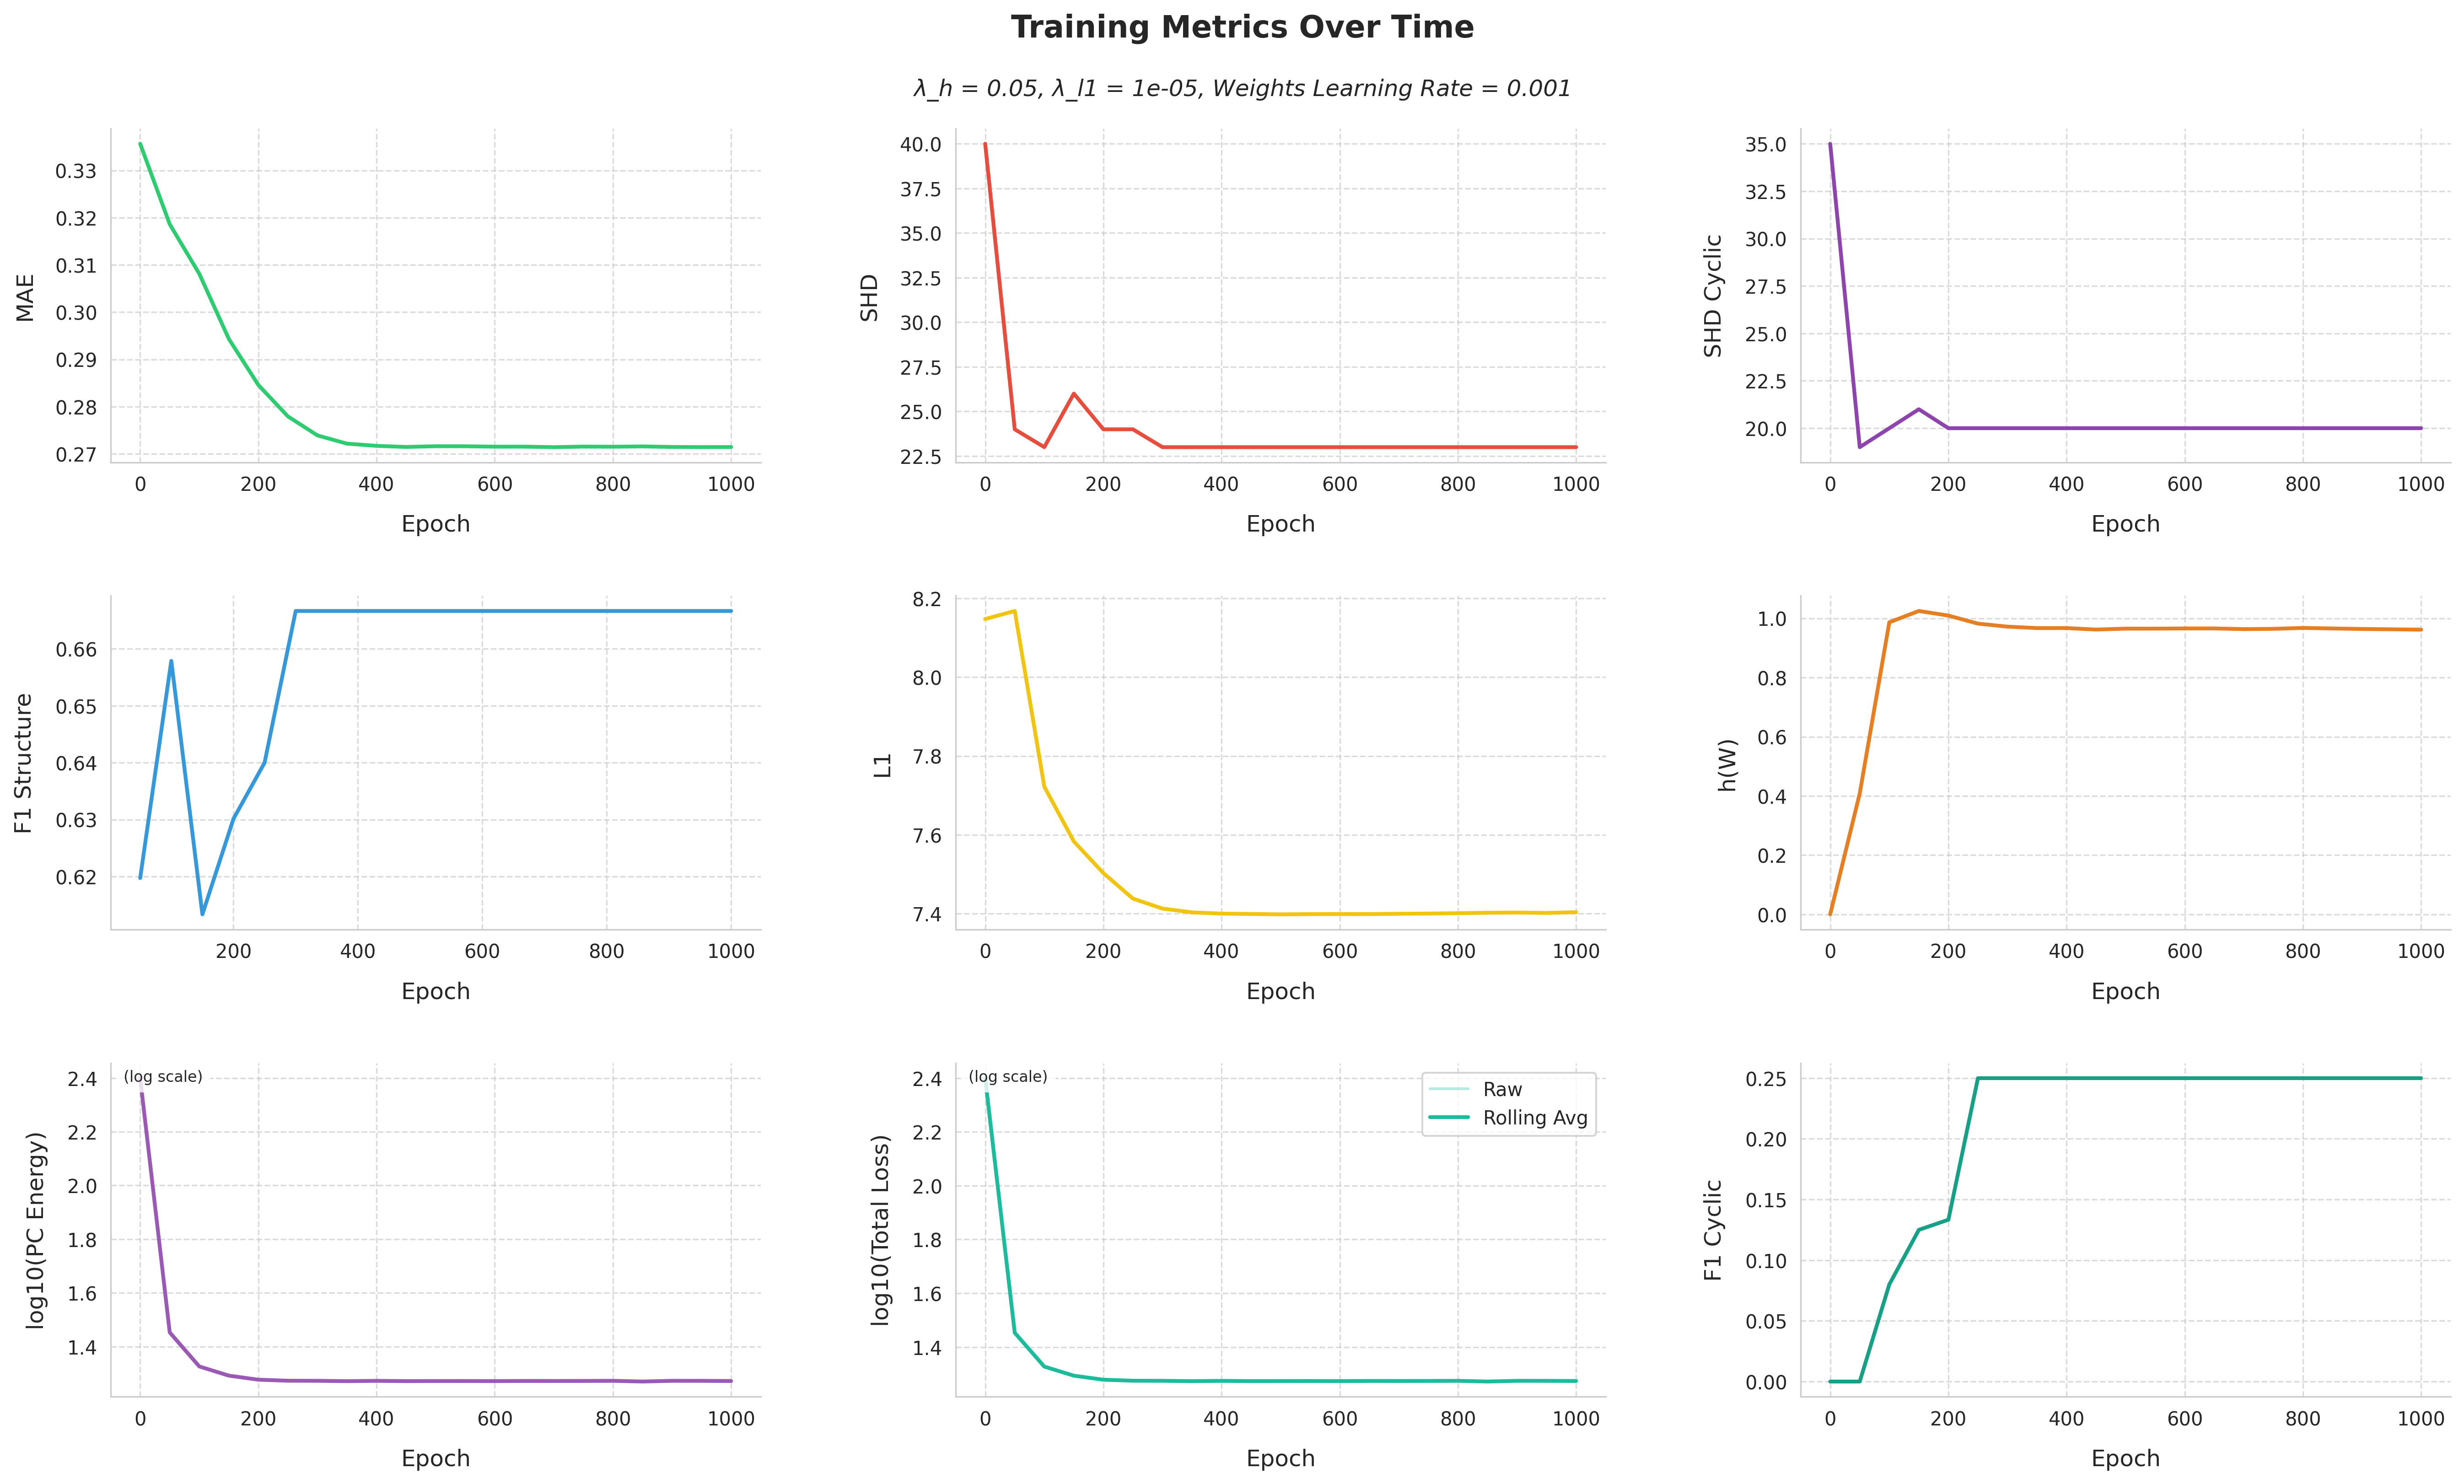

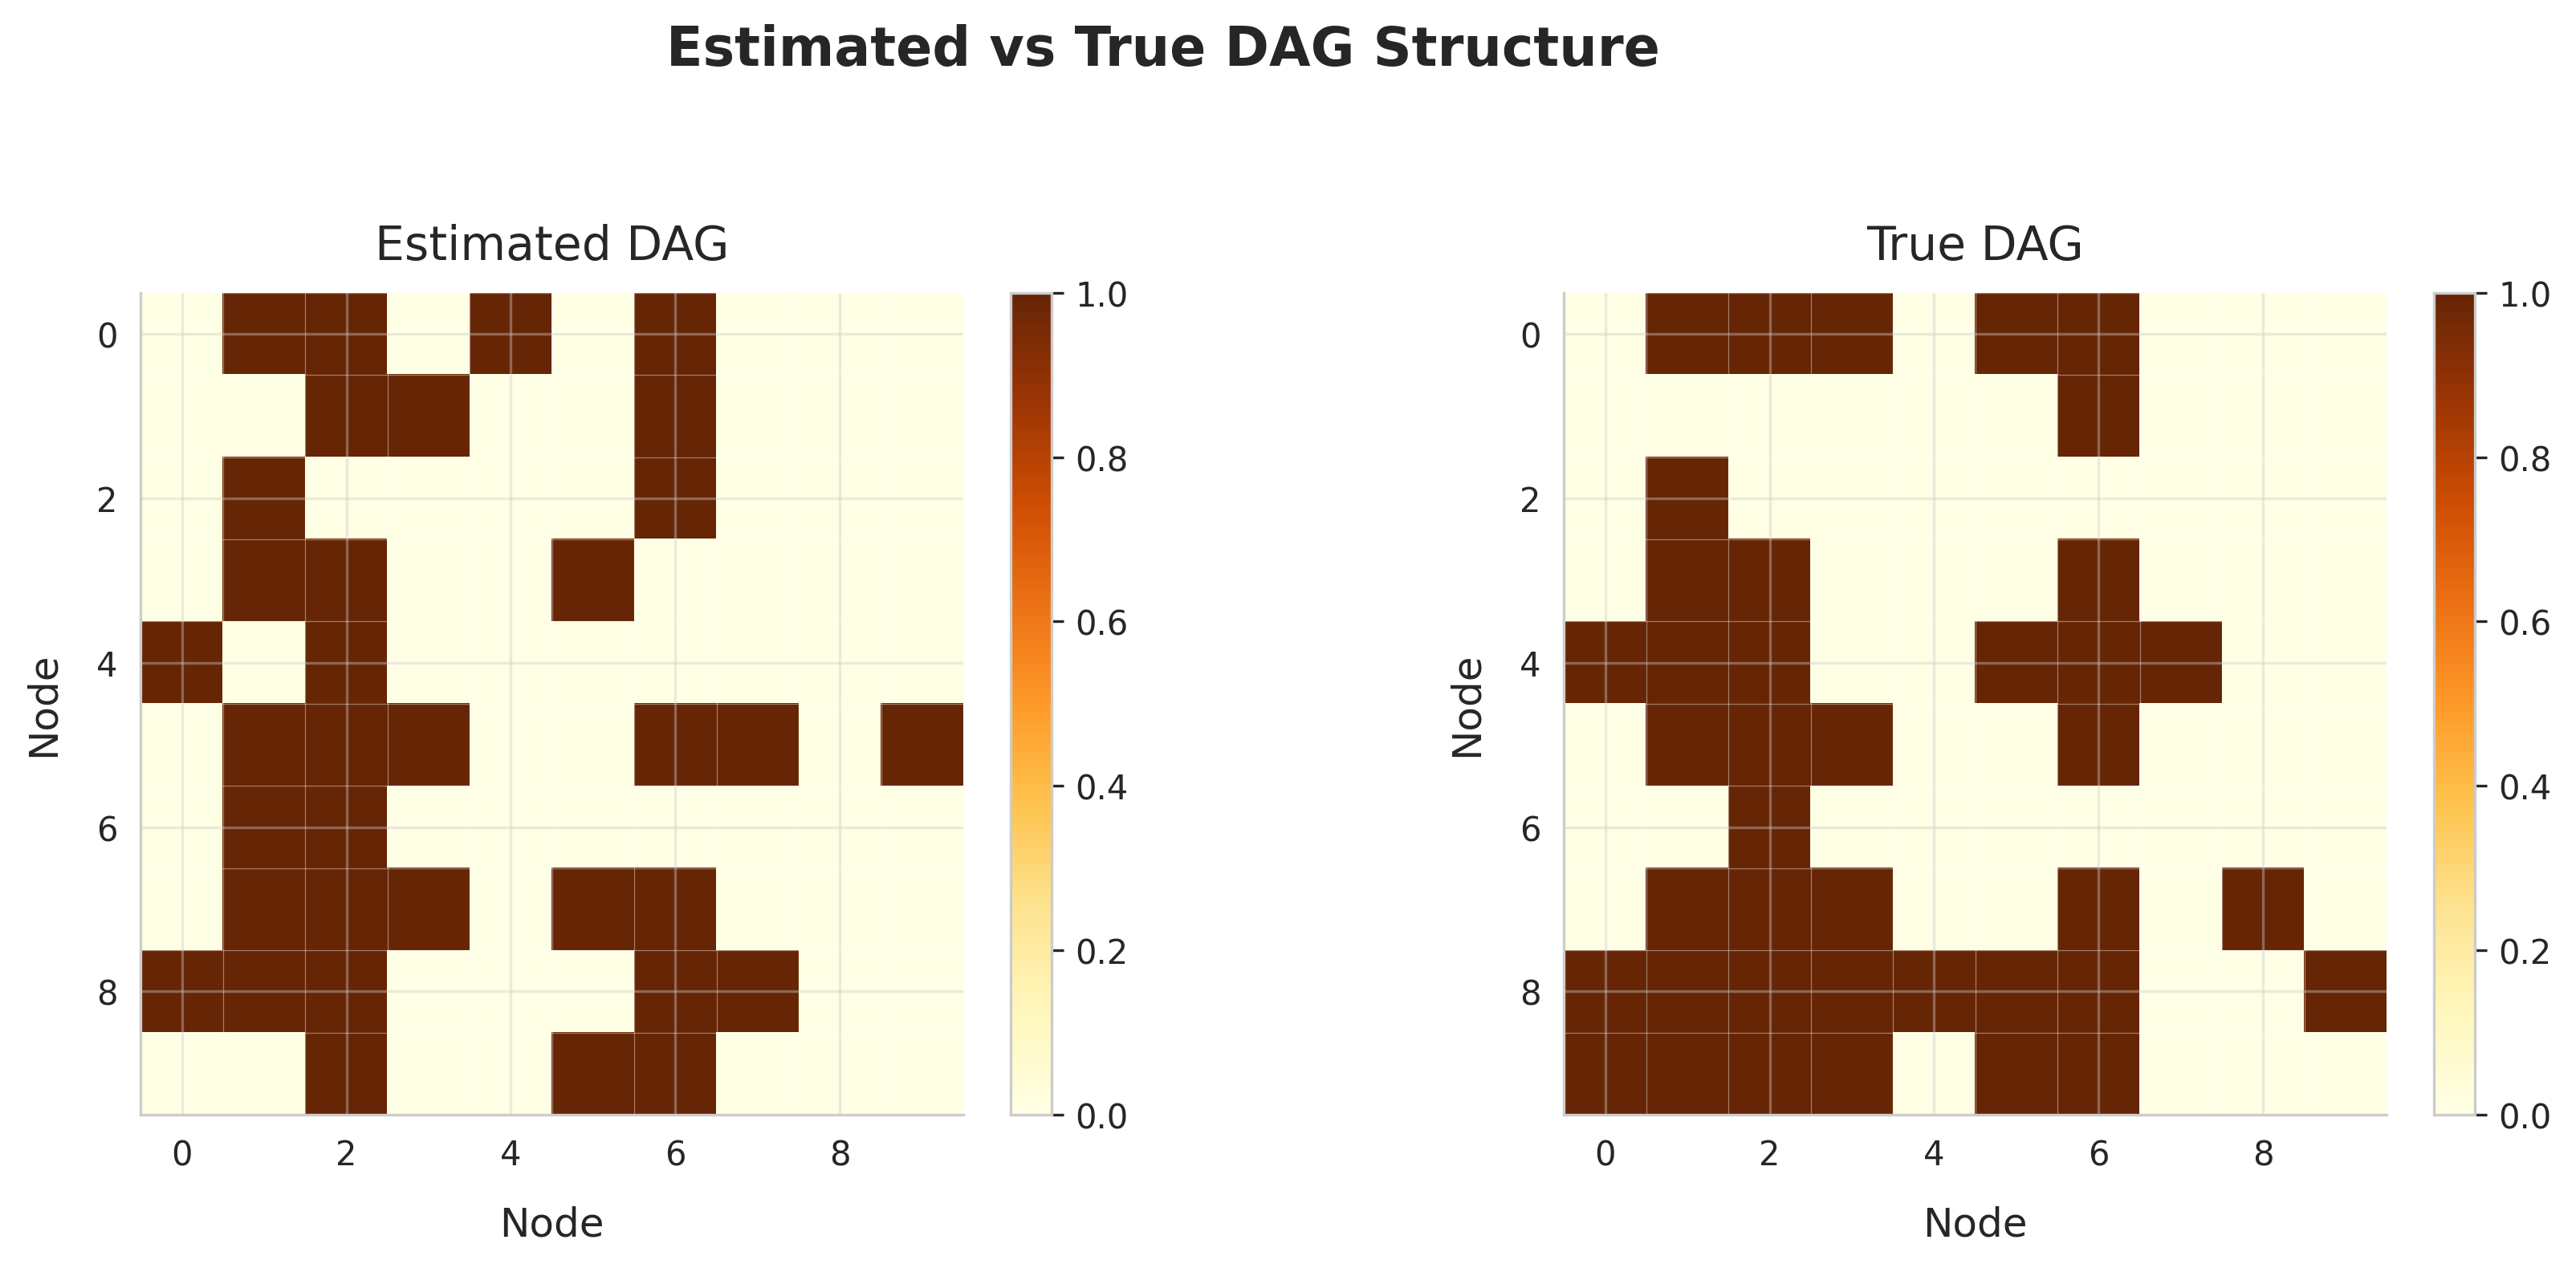

Is the estimated binary adjacency matrix a DAG? False

The h_reg term for the TRUE weighted adjacency matrix W_true is: 0.3174
The h_reg term for the EST weighted adjacency matrix W_est is: 0.9615

The number of edges in the TRUE graph: 40.0
The number of edges in the EST graph: 35

The first 5 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.      0.7892  0.9035  0.275  -0.3907]
 [ 0.221   0.     -0.357   0.3686  0.0551]
 [ 0.2174 -0.3317  0.     -0.2157  0.2205]
 [ 0.1866  0.8236 -0.4658  0.      0.0845]
 [-0.5104  0.2632  1.0207  0.1727  0.    ]]


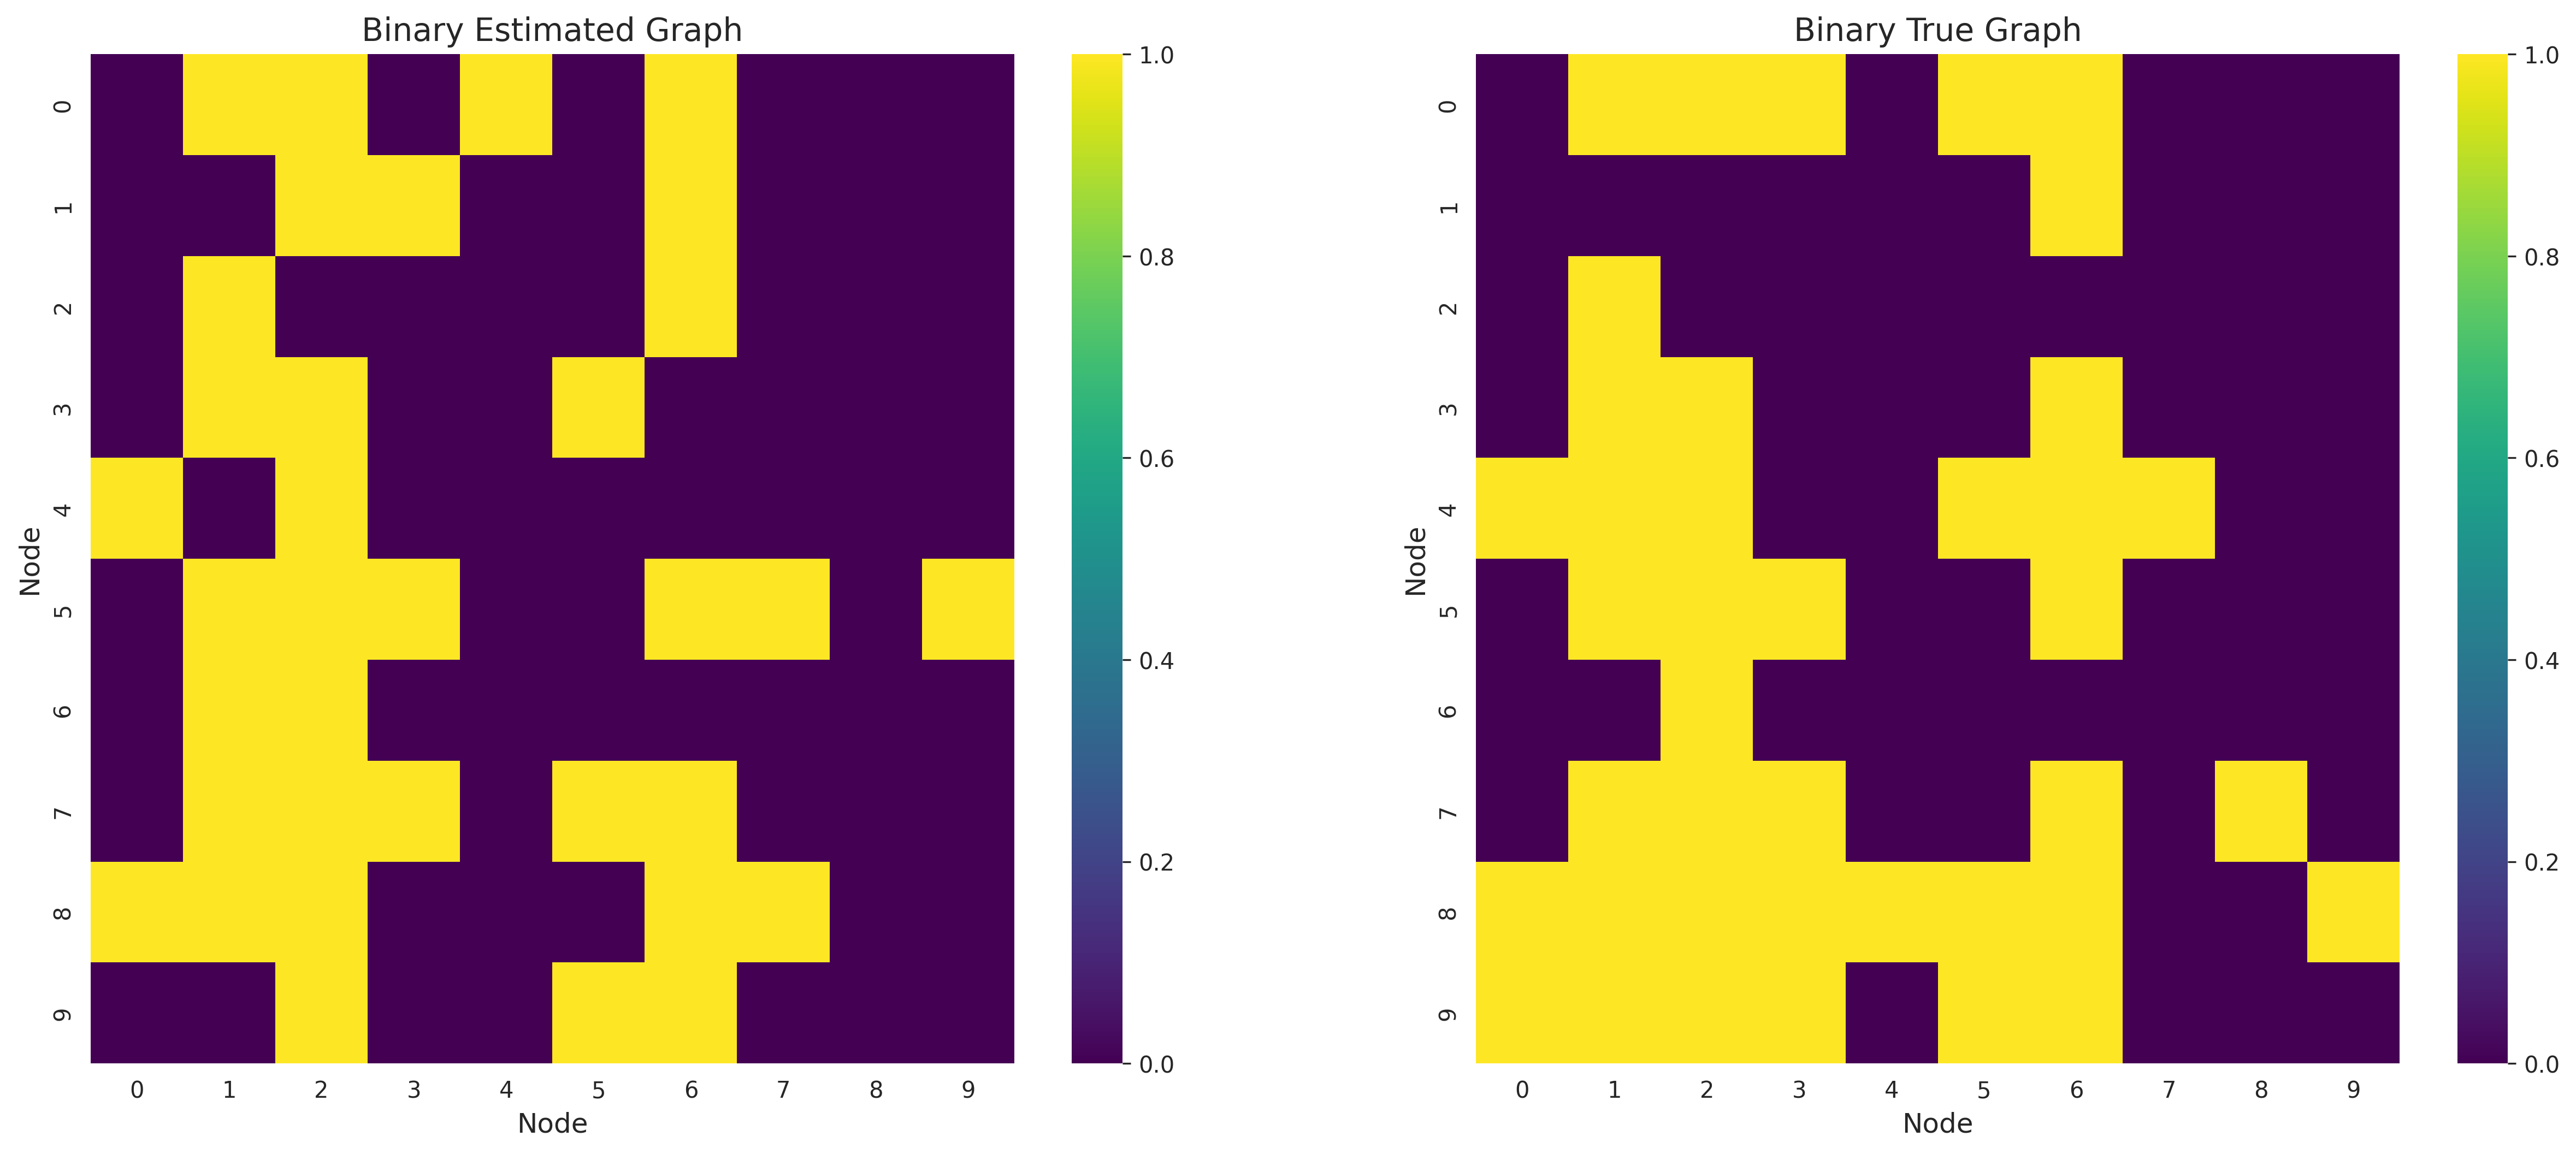

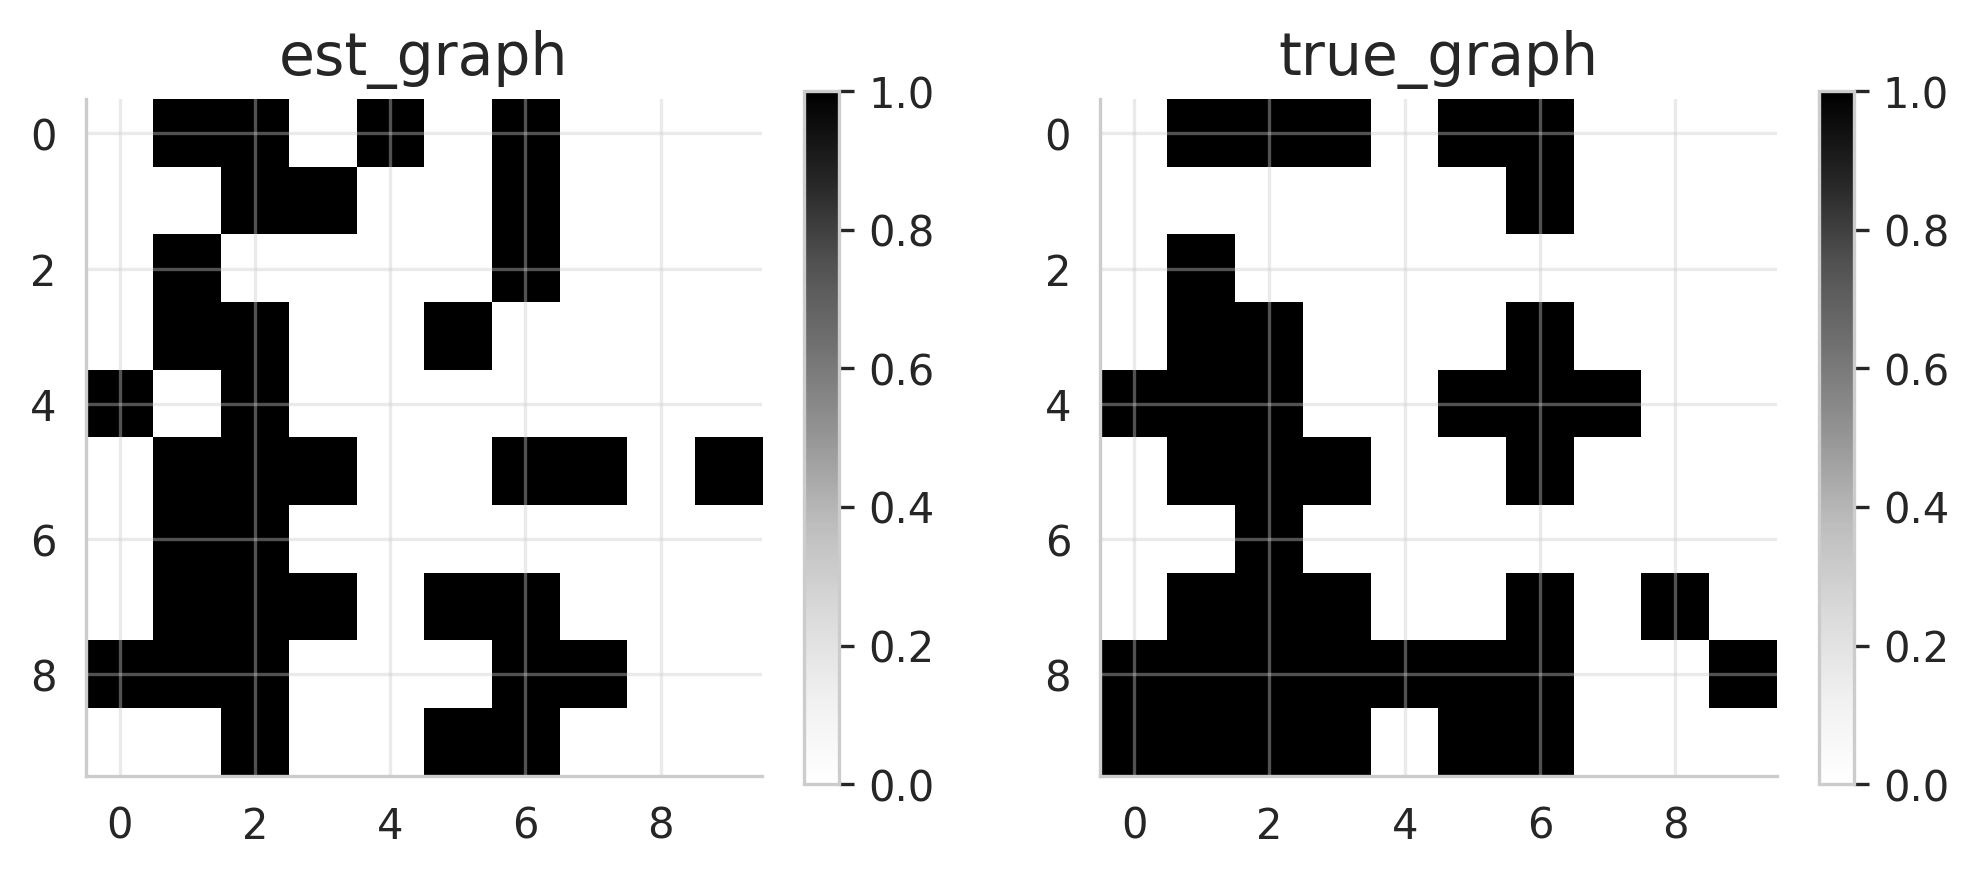

{'fdr': 0.0741, 'tpr': 0.625, 'fpr': 0.4, 'shd': 16, 'nnz': 27, 'precision': 0.7143, 'recall': 0.625, 'F1': 0.6667, 'gscore': 0.375}


In [205]:
# Define experiment name
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"

# Create subdirectory in linear folder with the name stored in exp_name
save_path = os.path.join('plots/linear_cyclic', exp_name)
os.makedirs(save_path, exist_ok=True)

# Reset to default style and set seaborn style
plt.style.use('default')
sns.set_style("whitegrid")

# Update matplotlib parameters
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.4,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Create a figure and subplots using GridSpec with 3x3 layout
fig = plt.figure(figsize=(22, 12))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

# Adjust layout to make room for titles and subtitles
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Create axes
axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)]

# Updated plot configurations
plot_configs = [
    {'metric': MAEs, 'title': 'MAE', 'ylabel': 'MAE', 'color': '#2ecc71', 'ax': axes[0]},
    {'metric': SHDs, 'title': 'SHD', 'ylabel': 'SHD', 'color': '#e74c3c', 'ax': axes[1]},
    {'metric': SHDs_cyclic, 'title': 'SHD Cyclic', 'ylabel': 'SHD Cyclic', 'color': '#8e44ad', 'ax': axes[2]},
    {'metric': F1s, 'title': 'F1 Score', 'ylabel': 'F1 Structure', 'color': '#3498db', 'ax': axes[3]},
    {'metric': l1_regs, 'title': 'L1 Regularization', 'ylabel': 'L1', 'color': '#f1c40f', 'ax': axes[4]},
    {'metric': h_regs, 'title': 'DAG Constraint', 'ylabel': 'h(W)', 'color': '#e67e22', 'ax': axes[5]},
    {'metric': pc_energies, 'title': 'PC Energy', 'ylabel': 'PC Energy', 'color': '#9b59b6', 'ax': axes[6]},
    {'metric': objs, 'title': 'Total Objective', 'ylabel': 'Total Loss', 'color': '#1abc9c', 'ax': axes[7]},
    {'metric': F1s_cycles, 'title': 'F1 Cyclic', 'ylabel': 'F1 Cyclic', 'color': '#16a085', 'ax': axes[8]}
]

# Create all subplots
for config in plot_configs:
    ax = config['ax']

    epochs = range(0, len(config['metric']) * every_n_epochs, every_n_epochs)
    
    # Determine if we should use log scale and/or scaling factor
    use_log_scale = config['title'] in ['PC Energy', 'Total Objective']
    #scale_factor = 1e4 if config['title'] == 'DAG Constraint' else 1
    scale_factor = 1 if config['title'] == 'DAG Constraint' else 1
    
    # Apply scaling and/or log transform to the metric
    metric_values = np.array(config['metric'])
    if use_log_scale:
        # Add small constant to avoid log(0)
        metric_values = np.log10(np.abs(metric_values) + 1e-10)
    metric_values = metric_values * scale_factor

    # Plot raw data
    ax.plot(epochs, metric_values, alpha=0.3, color=config['color'], label='Raw')

    # Calculate rolling average
    window_size = max(1, len(metric_values) // 50)  # Dynamic window size based on number of epochs
    if len(metric_values) > window_size:
        rolling_mean = np.convolve(metric_values, np.ones(window_size) / window_size, mode='valid')
        ax.plot(epochs[window_size - 1:], rolling_mean, color=config['color'], linewidth=2, label='Rolling Avg')

    # Customize subplot
    ax.set_xlabel('Epoch', labelpad=10)
    # Adjust ylabel based on transformations
    ylabel = config['ylabel']
    if use_log_scale:
        ylabel = f'log10({ylabel})'
    if scale_factor != 1:
        ylabel = f'{ylabel} (×{int(scale_factor)})'
    ax.set_ylabel(ylabel, labelpad=10)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend for Total Objective plot
    if config['title'] == 'Total Objective':
        ax.legend(loc='upper right')

    # Add note about scaling if applicable
    if use_log_scale or scale_factor != 1:
        transform_text = []
        if use_log_scale:
            transform_text.append('log scale')
        if scale_factor != 1:
            transform_text.append(f'×{int(scale_factor)}')
        ax.text(0.02, 0.98, f"({', '.join(transform_text)})", 
                transform=ax.transAxes, 
                fontsize=8, 
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))        

# Add overall title and subtitle with adjusted positions
fig.suptitle('Training Metrics Over Time', 
             fontsize=16, 
             weight='bold', 
             y=0.95)  # Lower the main title slightly

subtitle = f'λ_h = {lam_h}, λ_l1 = {lam_l1}, Weights Learning Rate = {w_learning_rate}'
fig.text(0.5, 0.90,  # Adjusted y position for the subtitle
         subtitle, 
         horizontalalignment='center',
         fontsize=12,
         style='italic')

# Adjust layout to make more room for title and subtitle
plt.subplots_adjust(top=0.88, hspace=0.4, wspace=0.3)


# Save and show the figure as a .pdf file
plt.savefig(os.path.join(save_path, 'training_metrics.pdf'), bbox_inches='tight', dpi=300)
plt.show()

########################## Plotting the DAG comparison  ##########################

# Create a separate figure for the adjacency matrices comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Use a better colormap - options:
# 'YlOrBr' - Yellow-Orange-Brown (good for sparse matrices)
# 'viridis' - Perceptually uniform, colorblind-friendly
# 'Greys' - Black and white, professional
# 'YlGnBu' - Yellow-Green-Blue, professional
cmap = 'YlOrBr'  # Choose one of the above

# Plot estimated adjacency matrix (now on the left)
im1 = ax1.imshow(compute_binary_adjacency(W), cmap=cmap, interpolation='nearest')
ax1.set_title('Estimated DAG', pad=10)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel('Node', labelpad=10)
ax1.set_ylabel('Node', labelpad=10)

# Plot true adjacency matrix (now on the right)
im2 = ax2.imshow(B_true, cmap=cmap, interpolation='nearest')
ax2.set_title('True DAG', pad=10)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_xlabel('Node', labelpad=10)
ax2.set_ylabel('Node', labelpad=10)

# Add overall title
fig.suptitle('Estimated vs True DAG Structure', 
             fontsize=16, 
             weight='bold', 
             y=1.05)

# Add grid lines to better separate the nodes
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

# Improve layout
plt.tight_layout()

# Save the comparison plot as a .pdf file at the specified location
plt.savefig(os.path.join(save_path, 'dag_comparison.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            facecolor='white',
            edgecolor='none')
plt.show()

# %%
# Now use a threshold of 0.3 to binarize the weighted adjacency matrix W
W_est = np.array(model.get_W())
B_est = compute_binary_adjacency(W_est, threshold=0.3)

# Check if the estimated binary adjacency matrix B_est is a DAG
is_dag_B_est = is_dag_nx(B_est)
print(f"Is the estimated binary adjacency matrix a DAG? {is_dag_B_est}")

print()

# Compute the h_reg term for the true weighted adjacency matrix W_true
h_reg_true = compute_h_reg(W_true)
print(f"The h_reg term for the TRUE weighted adjacency matrix W_true is: {h_reg_true:.4f}")
# Compute the h_reg term for the estimated weighted adjacency matrix W_est
h_reg_est = compute_h_reg(W_est)
print(f"The h_reg term for the EST weighted adjacency matrix W_est is: {h_reg_est:.4f}")

print()

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the TRUE graph: {np.sum(B_true)}")
print(f"The number of edges in the EST graph: {np.sum(B_est)}")

# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print()

print("The first 5 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:5, :5]))

# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(true_matrix=B_true, est_matrix=B_est, save_path=os.path.join(save_path, 'adjacency_matrices.png'))


# %%
# plot est_dag and true_dag
GraphDAG(B_est, B_true, save_name=os.path.join(save_path, 'est_dag_true_dag.png'))
# calculate accuracy
met_pcx = MetricsDAG(B_est, B_true) # expects first arg to be the predicted labels and the second arg to be the true labels
print(met_pcx.metrics)

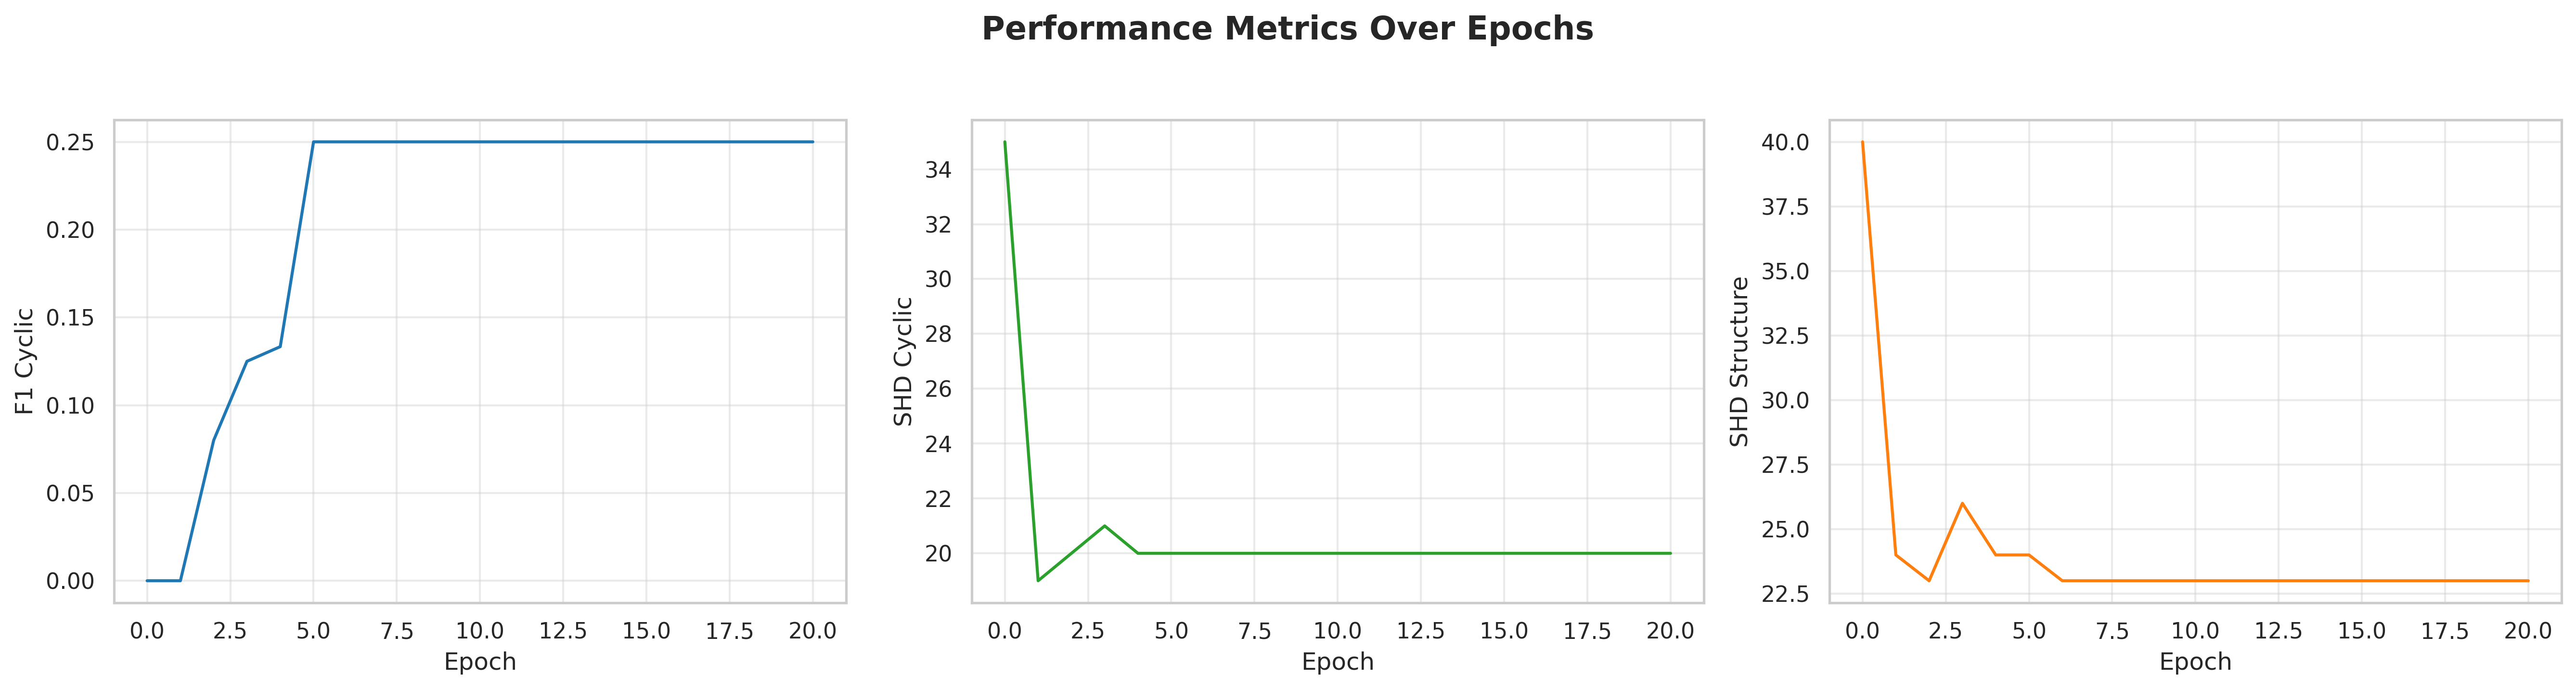

In [206]:
# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting layout to 1 row and 3 columns
fig.suptitle('Performance Metrics Over Epochs', fontsize=16, weight='bold')

# Plot the Cyclic F1 score
sns.lineplot(x=range(len(F1s_cycles)), y=F1s_cycles, ax=axs[0], color=palette[0])
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].set_ylabel("F1 Cyclic", fontsize=12)
axs[0].grid(True)

# Plot the Cyclic SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs_cyclic, ax=axs[1], color=palette[2])
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].set_ylabel("SHD Cyclic", fontsize=12)
axs[1].grid(True)

# Plot the vanilla SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs, ax=axs[2], color=palette[1])
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_ylabel("SHD Structure", fontsize=12)
axs[2].grid(True)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

In [207]:
# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 4 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:11, :11]))

The first 4 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.      0.7892  0.9035  0.275  -0.3907 -0.1892 -0.7068  0.0755 -0.2715
   0.0308]
 [ 0.221   0.     -0.357   0.3686  0.0551 -0.2793  0.3201 -0.1602  0.1426
  -0.0346]
 [ 0.2174 -0.3317  0.     -0.2157  0.2205 -0.2227  0.3907 -0.2053  0.1066
   0.1727]
 [ 0.1866  0.8236 -0.4658  0.      0.0845  0.3881  0.1167  0.2436  0.0536
   0.0267]
 [-0.5104  0.2632  1.0207  0.1727  0.     -0.1042  0.097  -0.1057  0.102
  -0.2927]
 [-0.1338 -0.9125 -0.7647  0.4763 -0.0511  0.      0.7087 -0.4348 -0.0761
   0.3119]
 [-0.2227  0.3729  0.4896  0.0778  0.0471  0.2757  0.      0.1673 -0.1655
   0.1298]
 [ 0.0867 -0.7805 -0.8946  0.3803 -0.0616 -0.5668  0.6419  0.      0.2202
   0.1688]
 [-0.4356  0.8323  0.7223  0.1126  0.0977 -0.1597 -0.8257  0.3464  0.
   0.2408]
 [ 0.0434 -0.0822  0.7627  0.0459 -0.2797  0.5078  0.3691  0.1984  0.2022
   0.    ]]


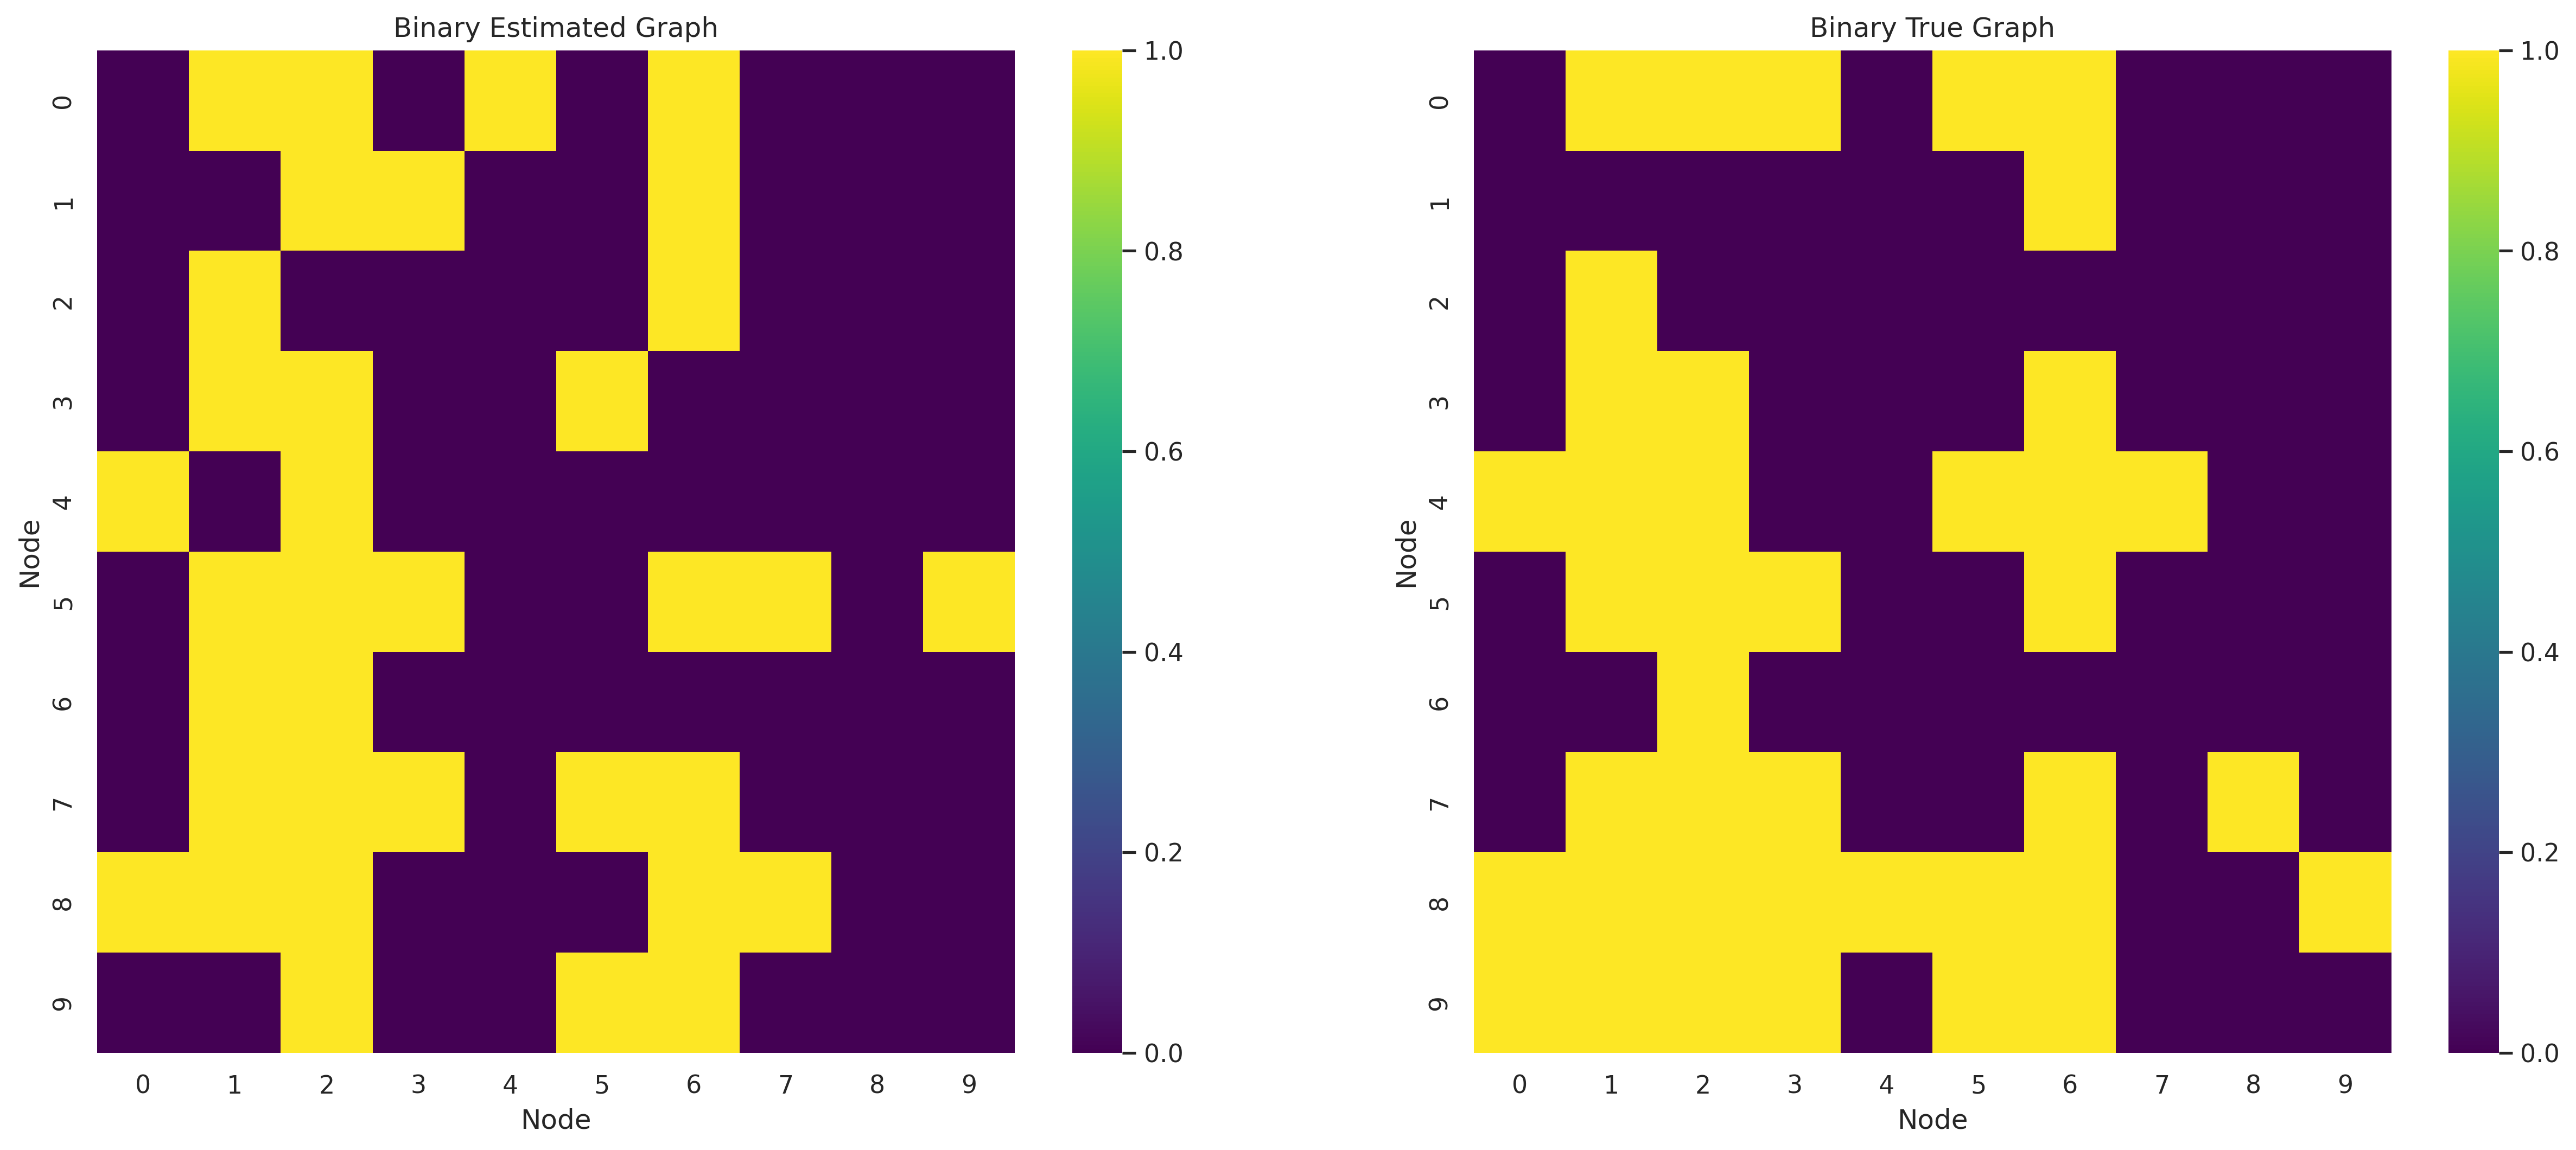

The number of edges in the estimated graph: 35
The number of edges in the true graph: 40.0


In [208]:
# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(B_true, B_est)

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")
print(f"The number of edges in the true graph: {np.sum(B_true)}")

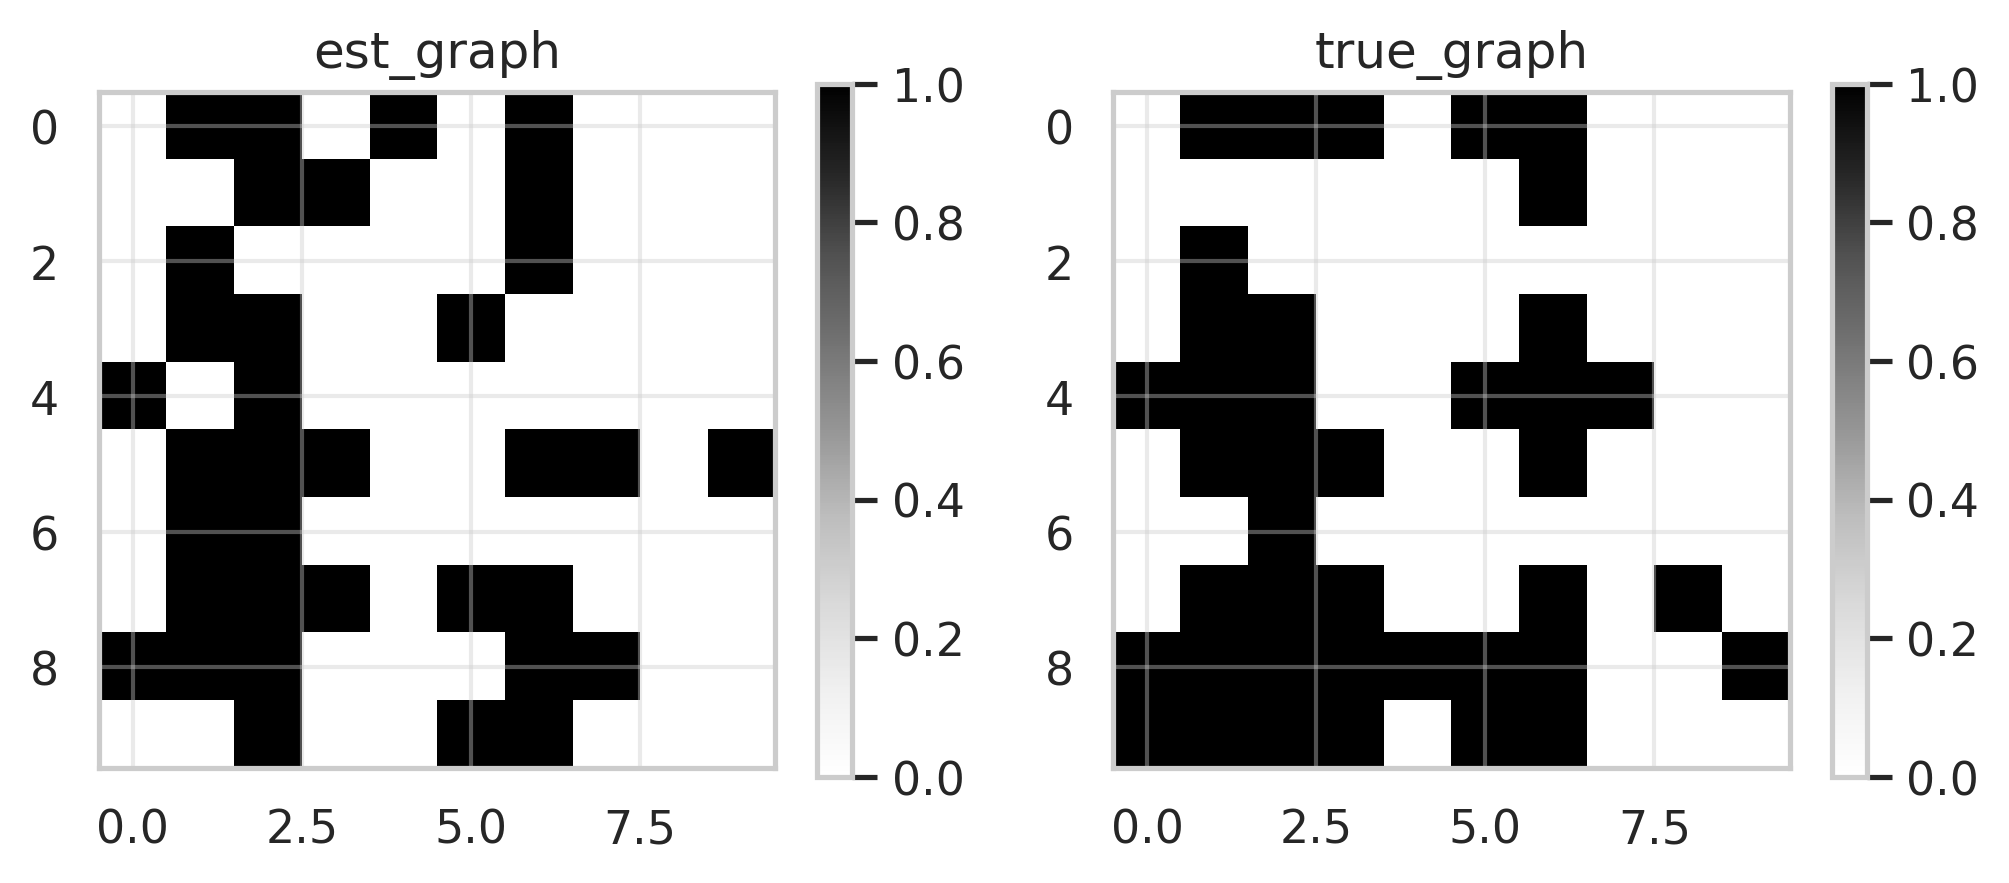

{'fdr': 0.0741, 'tpr': 0.625, 'fpr': 0.4, 'shd': 16, 'nnz': 27, 'precision': 0.7143, 'recall': 0.625, 'F1': 0.6667, 'gscore': 0.375}
bs_256_lrw_0.001_lrh_0.0001_lamh_0.05_laml1_1e-05_epochs_1000


In [209]:
# plot est_dag and true_dag
GraphDAG(B_est, B_true)
# calculate accuracy
met_pcax = MetricsDAG(B_est, B_true)
print(met_pcax.metrics)

# print experiment name
print(exp_name)

Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)


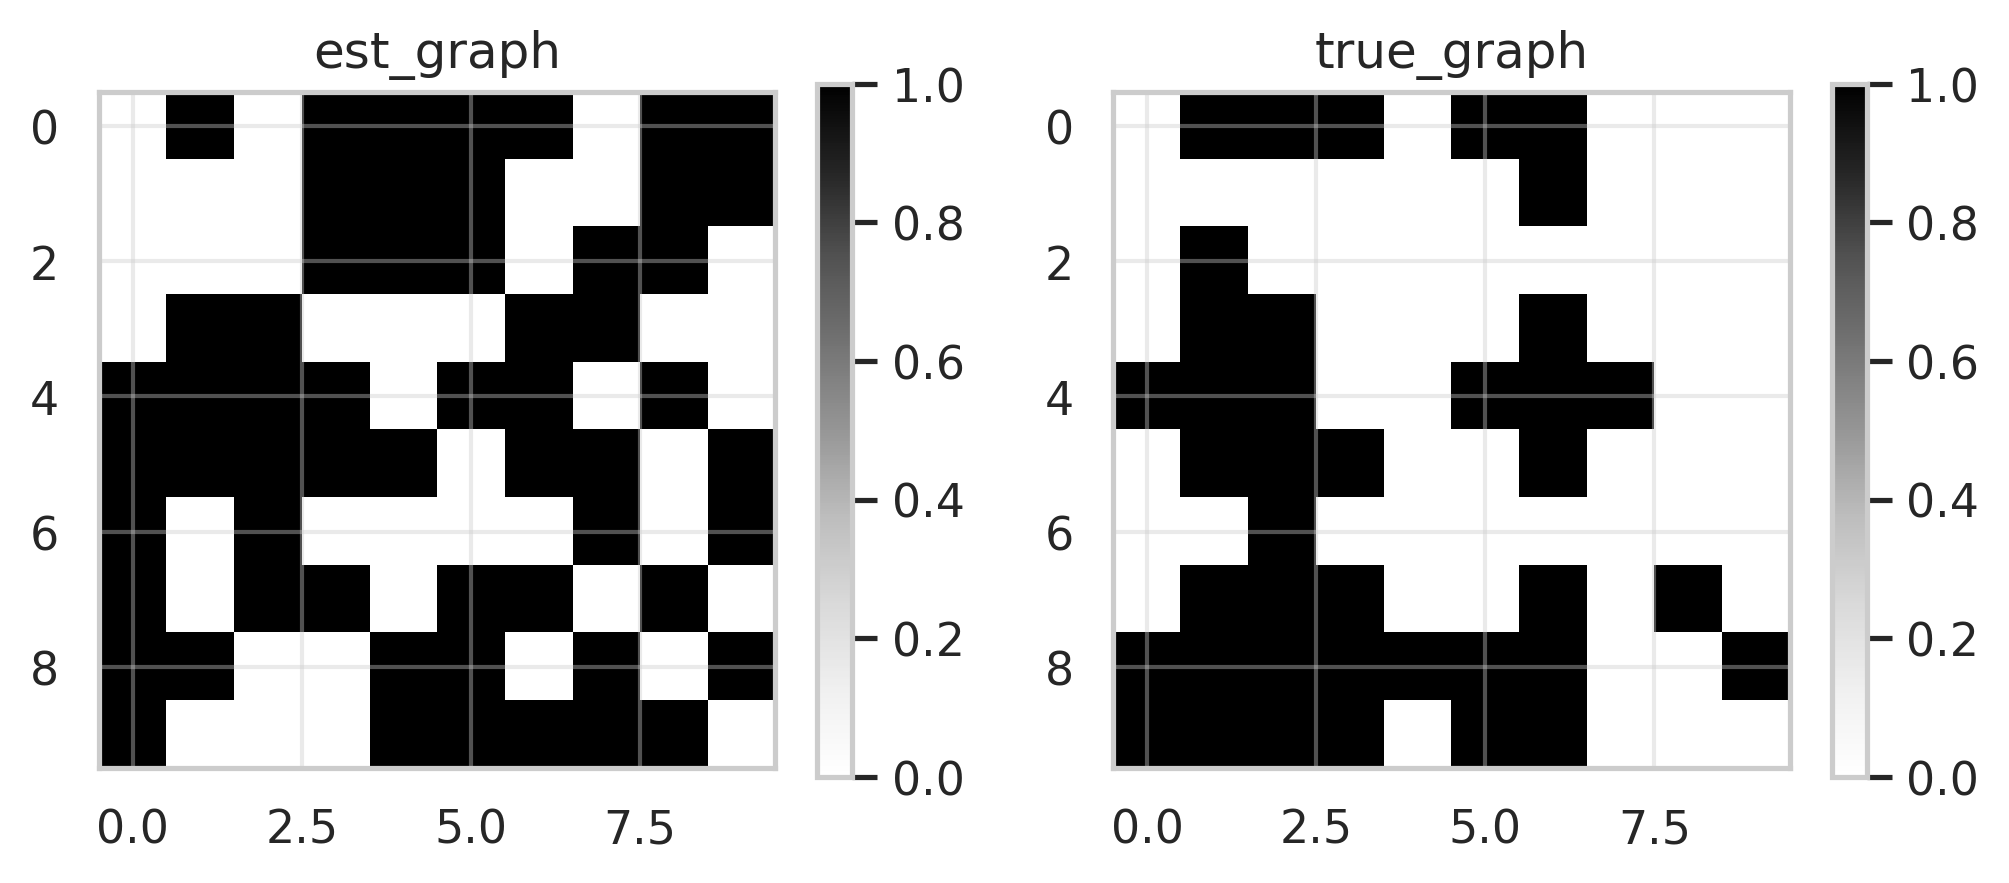

{'fdr': 0.1944, 'tpr': 0.725, 'fpr': 1.4, 'shd': 16, 'nnz': 36, 'precision': 0.5, 'recall': 0.725, 'F1': 0.5918, 'gscore': 0.0}


In [15]:
# nodags

# the below setup is taken from the nodags-flows/validation /run_synthetic_benchmark.py file which runs on linear data

# Initialize the NODAGS model with linear functions
resblock = resflow_train_test_wrapper(
    n_nodes=X.shape[1],
    batch_size=128,
    l1_reg=False,
    fun_type='lin-mlp',  # Linear version
    act_fun='none', # No activation function
    lr=1e-3,
    lip_const=0.99,
    epochs=100,
    optim='adam',
    n_hidden=0,
    thresh_val=0.05,
    centered=False,
    v=False,
    inline=False,
    upd_lip=False,
    full_input=False,
)

# Train the model with only observational data
resblock.train([X], [[]], batch_size=64)

# get the weighted adjacency matrix
W_est_nodags = resblock.get_adjacency()
# get the binary adjacency matrix
B_est_nodags = (W_est_nodags > 0.3).astype(int)

# plot est_dag and true_dag
GraphDAG(B_est_nodags, B_true)
# calculate accuracy
met_nodags = MetricsDAG(B_est_nodags, B_true) # expects first arg to be the predicted labels and the second arg to be the true labels
print(met_nodags.metrics)

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


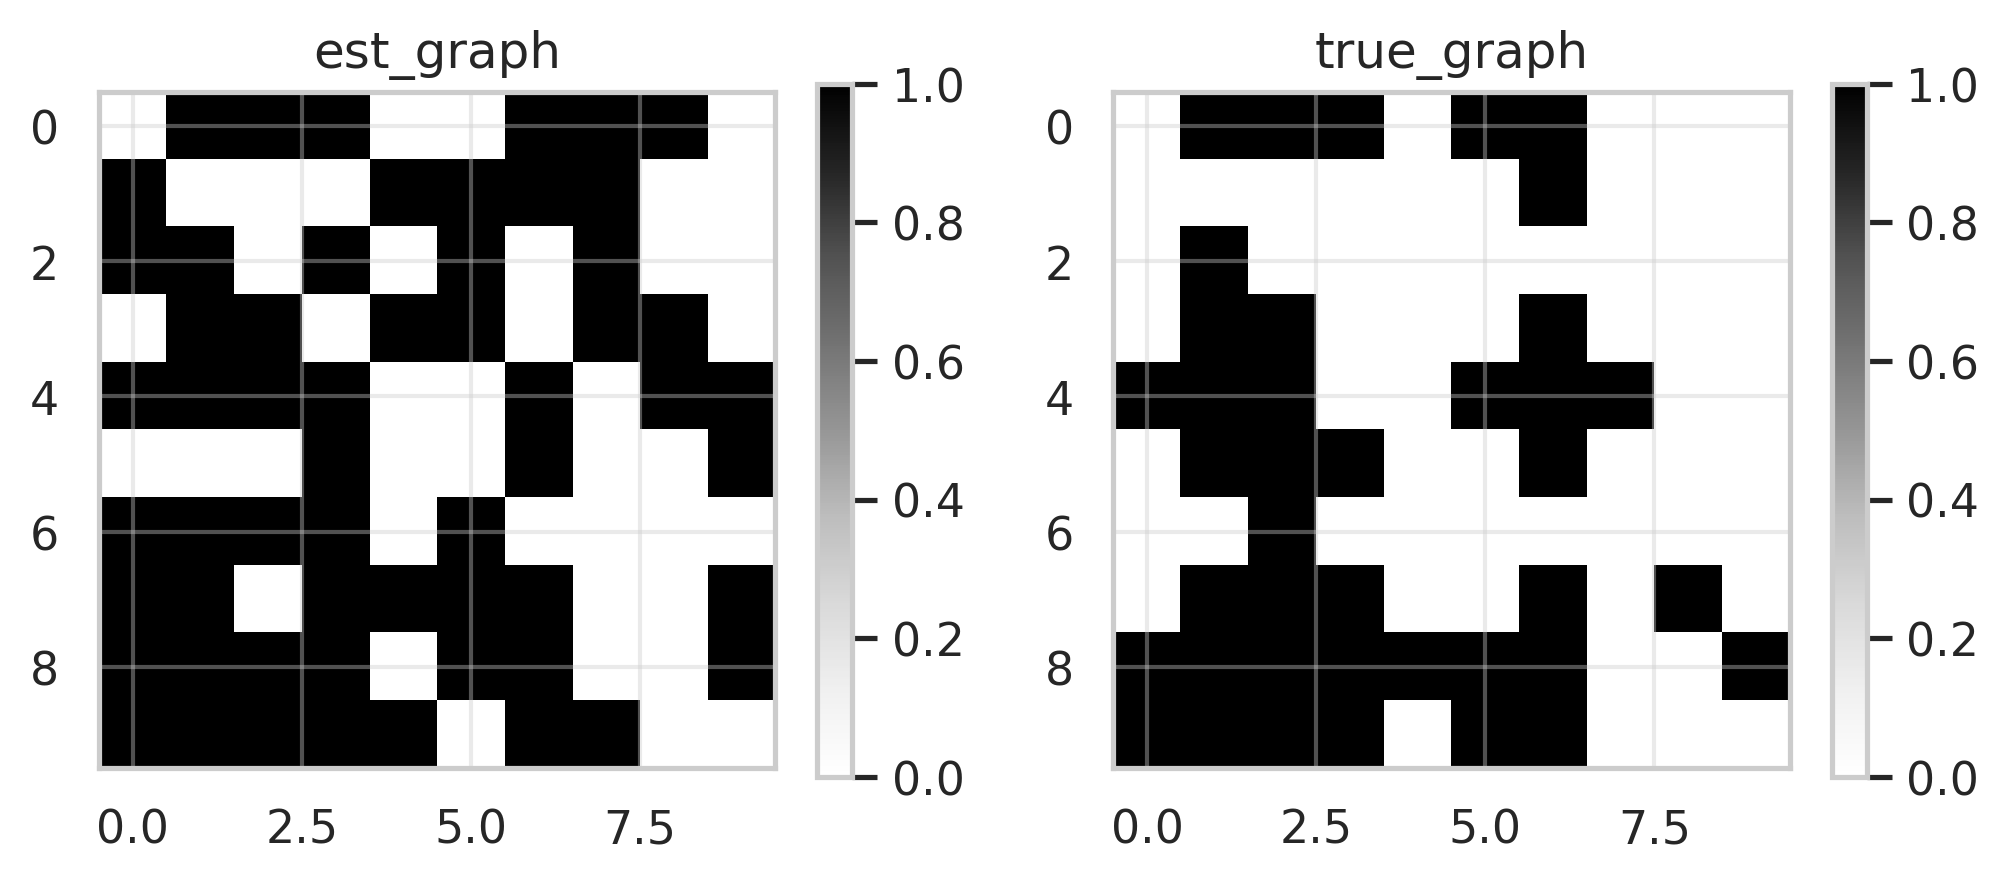

{'fdr': 0.2857, 'tpr': 0.75, 'fpr': 2.4, 'shd': 15, 'nnz': 42, 'precision': 0.5172, 'recall': 0.75, 'F1': 0.6122, 'gscore': 0.05}


In [16]:
# lingd

ling = LiNGD(k=1)
ling.fit(X)
W_ling = ling._adjacency_matrices[0].T # 0 because we are using k=1, Transpose to make each row correspond to parents
B_est_ling = compute_binary_adjacency(W_ling)

# plot est_dag and true_dag
GraphDAG(B_est_ling, B_true)
# calculate accuracy
met_ling = MetricsDAG(B_est_ling, B_true)
print(met_ling.metrics)

Add edge: 6 -> 5, Delta Score: 8.235e-01 best score: 0.8234651272014072
Add edge: 6 -> 9, Delta Score: 6.031e-01 best score: 1.426569659307223
Add edge: 0 -> 1, Delta Score: 5.929e-01 best score: 2.019467767938103
Add edge: 2 -> 3, Delta Score: 5.739e-01 best score: 2.593367846028101
Add edge: 0 -> 6, Delta Score: 4.901e-01 best score: 3.0834535286103133
Add edge: 5 -> 8, Delta Score: 3.849e-01 best score: 3.4683991278574107
Add edge: 2 -> 4, Delta Score: 3.774e-01 best score: 3.8458143644447857
Add edge: 3 -> 7, Delta Score: 2.119e-01 best score: 4.0576680515991566
Add edge: 3 -> 6, Delta Score: 1.709e-01 best score: 4.228559788207337
Add edge: 2 -> 5, Delta Score: 1.700e-01 best score: 4.398593981902283
Add edge: 1 -> 5, Delta Score: 3.092e-01 best score: 4.707828747137794
Add edge: 7 -> 5, Delta Score: 1.699e-01 best score: 4.8776822349900515
Add edge: 3 -> 5, Delta Score: 1.921e-01 best score: 5.069803627959507
Add edge: 3 -> 1, Delta Score: 1.598e-01 best score: 5.229608507572085


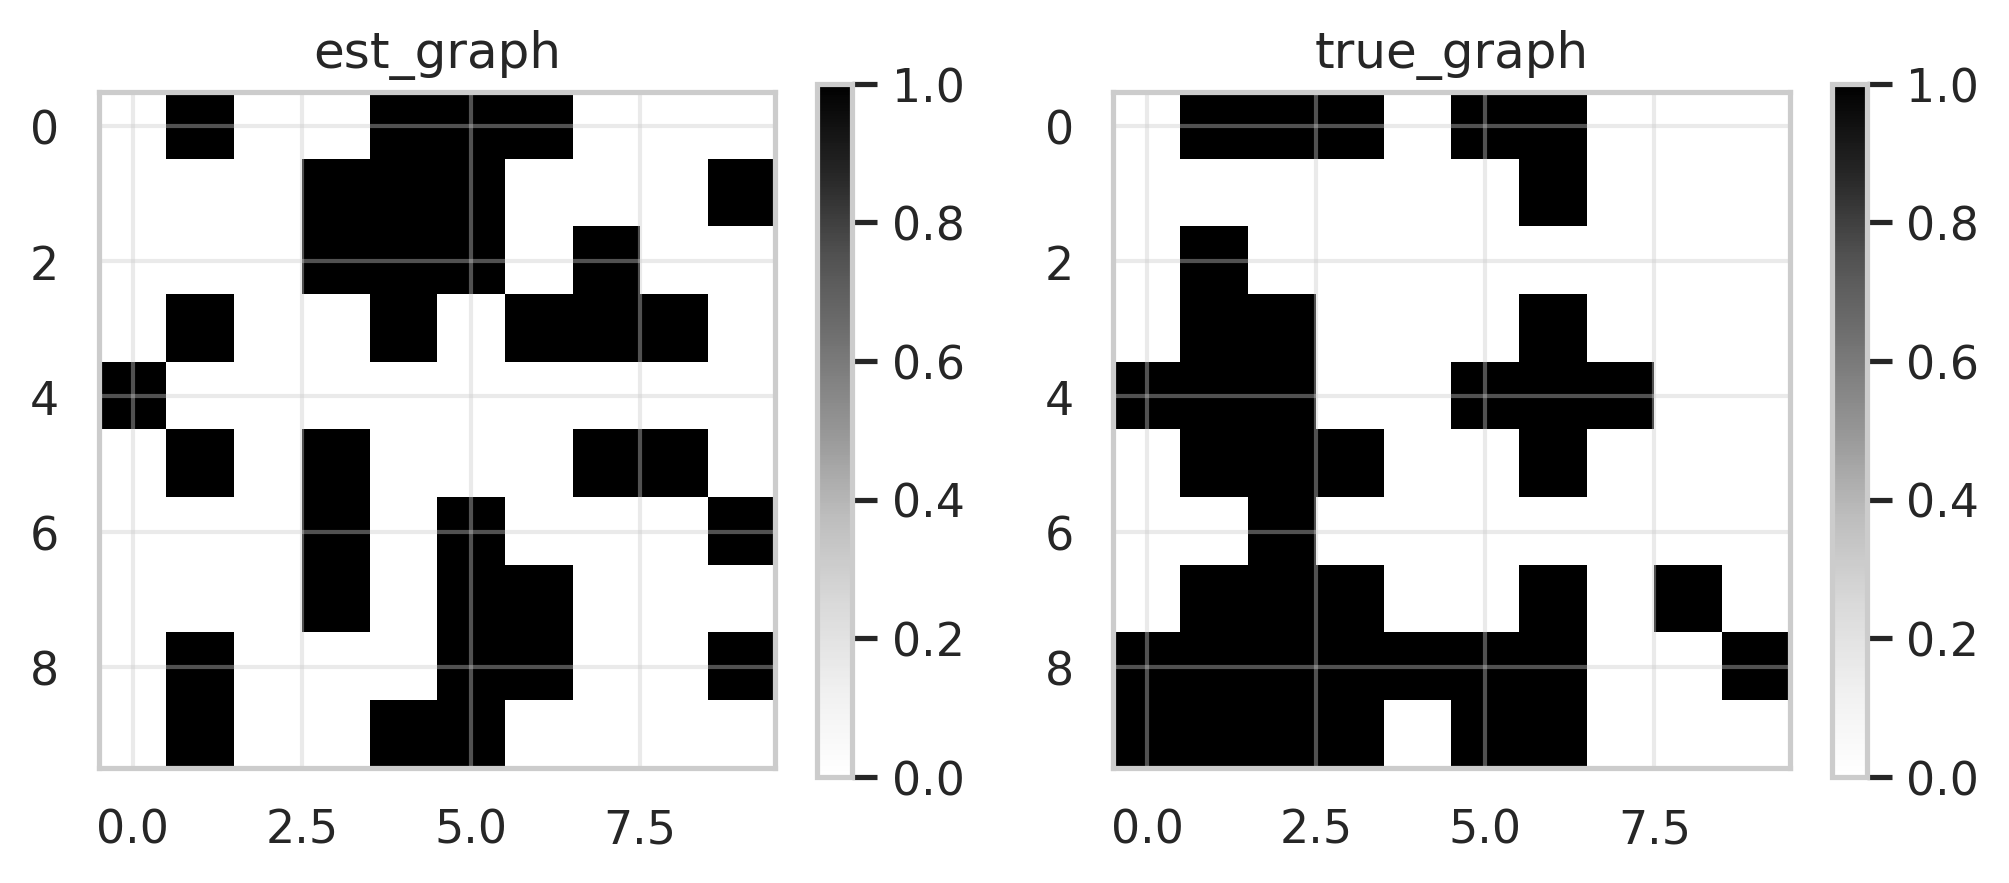

{'fdr': 0.4074, 'tpr': 0.4, 'fpr': 2.2, 'shd': 27, 'nnz': 27, 'precision': 0.4571, 'recall': 0.4, 'F1': 0.4267, 'gscore': 0.0}


In [17]:
# dglearn

tabu_length = 4
patience = 4
#max_iter = 10
max_iter = np.inf

manager = CyclicManager(X, bic_coef=0.5)
B_est_dglearn, best_score, log = tabu_search(manager, tabu_length, patience, max_iter=max_iter, first_ascent=False, verbose=1) # returns a binary matrix as learned support

# perform virtual edge correction
print("virtual edge correction...")
B_est_dglearn = virtual_refine(manager, B_est_dglearn, patience=0, max_iter=max_iter, max_path_len=6, verbose=1)

# remove any reducible edges
B_est_dglearn = reduce_support(B_est_dglearn, fill_diagonal=False)
# convert B_est_dglearn to boolean matrix in case it is not

# plot est_dag and true_dag
GraphDAG(B_est_dglearn, B_true)
# calculate accuracy
met_dglearn = MetricsDAG(B_est_dglearn, B_true)
print(met_dglearn.metrics)

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Starting pruning...Starting pruning...Starting pruning...Starting pruning...Starting pruning...




loss_theo_best: 1.1642552699697717e-08
loss_theo_best: 2.206052052144969e-08
loss_theo_best: 8.597243805752441e-09
# del edges: 35
# del edges: 35
loss_theo_best: 3.630514200381185e-08
loss_theo_best: 2.297312207133473e-08
# del edges: 35
# del edges: 35
loss: 0.17834732404331
# del edges: 18
loss: 0.12377987156648196
# del edges: 18
loss: 3.8610592056897985e-08
# del edges: 26
# del edges: 35
loss: 0.13882578102992404
# del edges: 18
loss: 6.954231235312136e-08
# del edges: 26
loss: 0.11734310061535425
# del edges: 18
loss: 3.912207979794857e-08
# del edges: 26
loss: 0.24822338896668317
# del edges: 18
loss: 0.00013619883957183276
# del edges: 26
loss: 0.0004328908209645377
# del edges: 30
loss: 0.003756448300719306
# del edges: 22
loss: 0.001184664810037539
# del edges: 26
loss: 7.500946264116237e-07
# del edges: 24
loss: 2.0046636350912195e-08
# del edges: 25
loss: 0.05131350865053452

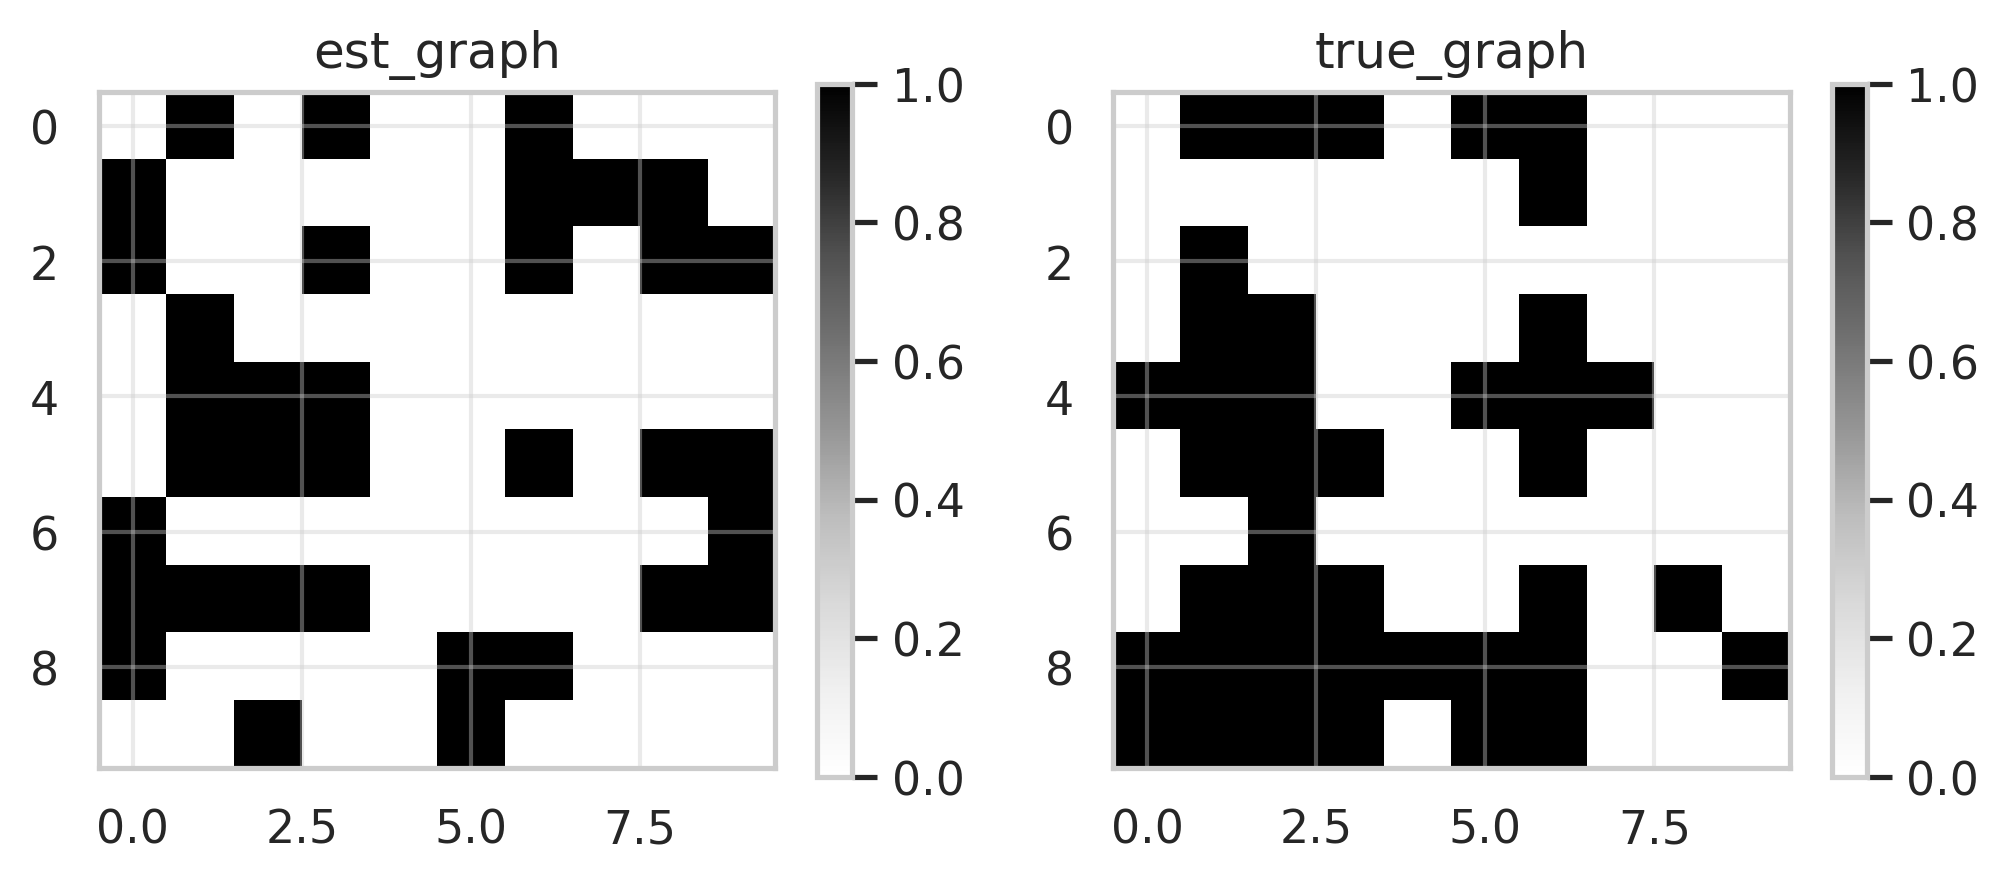

{'fdr': 0.3103, 'tpr': 0.5, 'fpr': 1.8, 'shd': 23, 'nnz': 29, 'precision': 0.5714, 'recall': 0.5, 'F1': 0.5333, 'gscore': 0.125}


In [18]:
# frp

edge_penalty = 0.5 * np.log(X.shape[0]) / X.shape[0] # BIC choice
frp_result = run_filter_rank_prune(
        X, 
        loss_type="kld",
        reg_type="scad",
        reg_params={"lam": edge_penalty, "gamma": 3.7},
        edge_penalty=edge_penalty,
        n_inits=5,
        n_threads=200,
        parcorr_thrs=0.1 * (X.shape[0] / 1000)**(-1/4),
        use_loss_cache=True,
        seed=seed,
        verbose=False,
)

B_est_frp = frp_result["learned_support"].astype(int)

# plot est_dag and true_dag
GraphDAG(B_est_frp, B_true)
# calculate accuracy
met_frp = MetricsDAG(B_est_frp, B_true)
print(met_frp.metrics)

2025-02-06 17:08:29,700 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:196] - INFO: [start]: n=5000, d=10, iter_=1000, h_=1e-05, rho_=1e+16
2025-02-06 17:08:43,118 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:229] - INFO: FINISHED


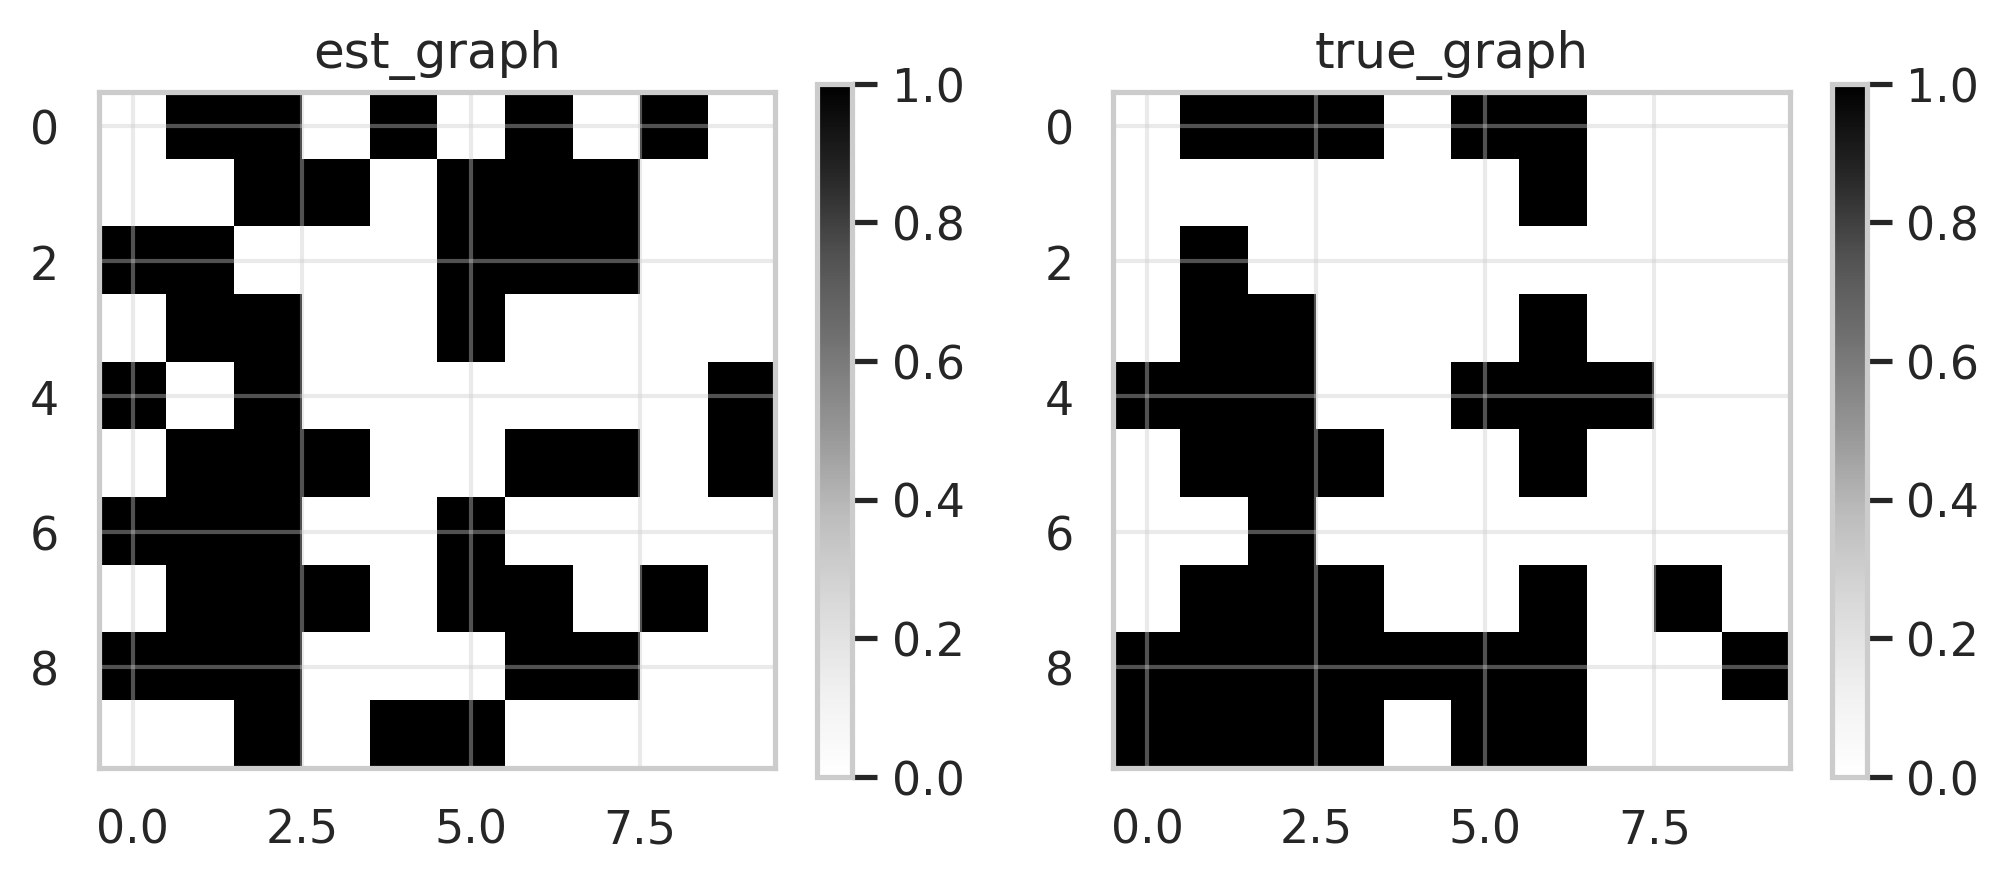

{'fdr': 0.0741, 'tpr': 0.625, 'fpr': 0.4, 'shd': 17, 'nnz': 27, 'precision': 0.5556, 'recall': 0.625, 'F1': 0.5882, 'gscore': 0.125}


In [19]:
# notears

nt = Notears(lambda1=1e-5, h_tol=1e-5, max_iter=1000, no_dag_constraint=True, loss_type='laplace') # default loss_type is 'l2'
#nt = Notears(lambda1=1e-5, h_tol=1e-5, max_iter=1000, no_dag_constraint=True, loss_type='logistic')
nt.learn(X)

# plot est_dag and true_dag
W_est_nt = np.array(nt.weight_causal_matrix)
B_est_nt = np.array(nt.causal_matrix)
GraphDAG(B_est_nt, B_true)

# calculate accuracy
met_nt = MetricsDAG(B_est_nt, B_true)
print(met_nt.metrics)

2025-02-06 17:08:43,381 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:124] - INFO: GPU is available.
2025-02-06 17:08:43,385 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:213] - INFO: Started training for 20000 iterations.
2025-02-06 17:08:43,429 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:226] - INFO: [Iter 0] score=62.028, likelihood=62.028, h=0.0e+00
2025-02-06 17:08:54,670 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:226] - INFO: [Iter 5000] score=53.188, likelihood=53.187, h=1.2e+01
2025-02-06 17:09:05,329 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:226] - IN

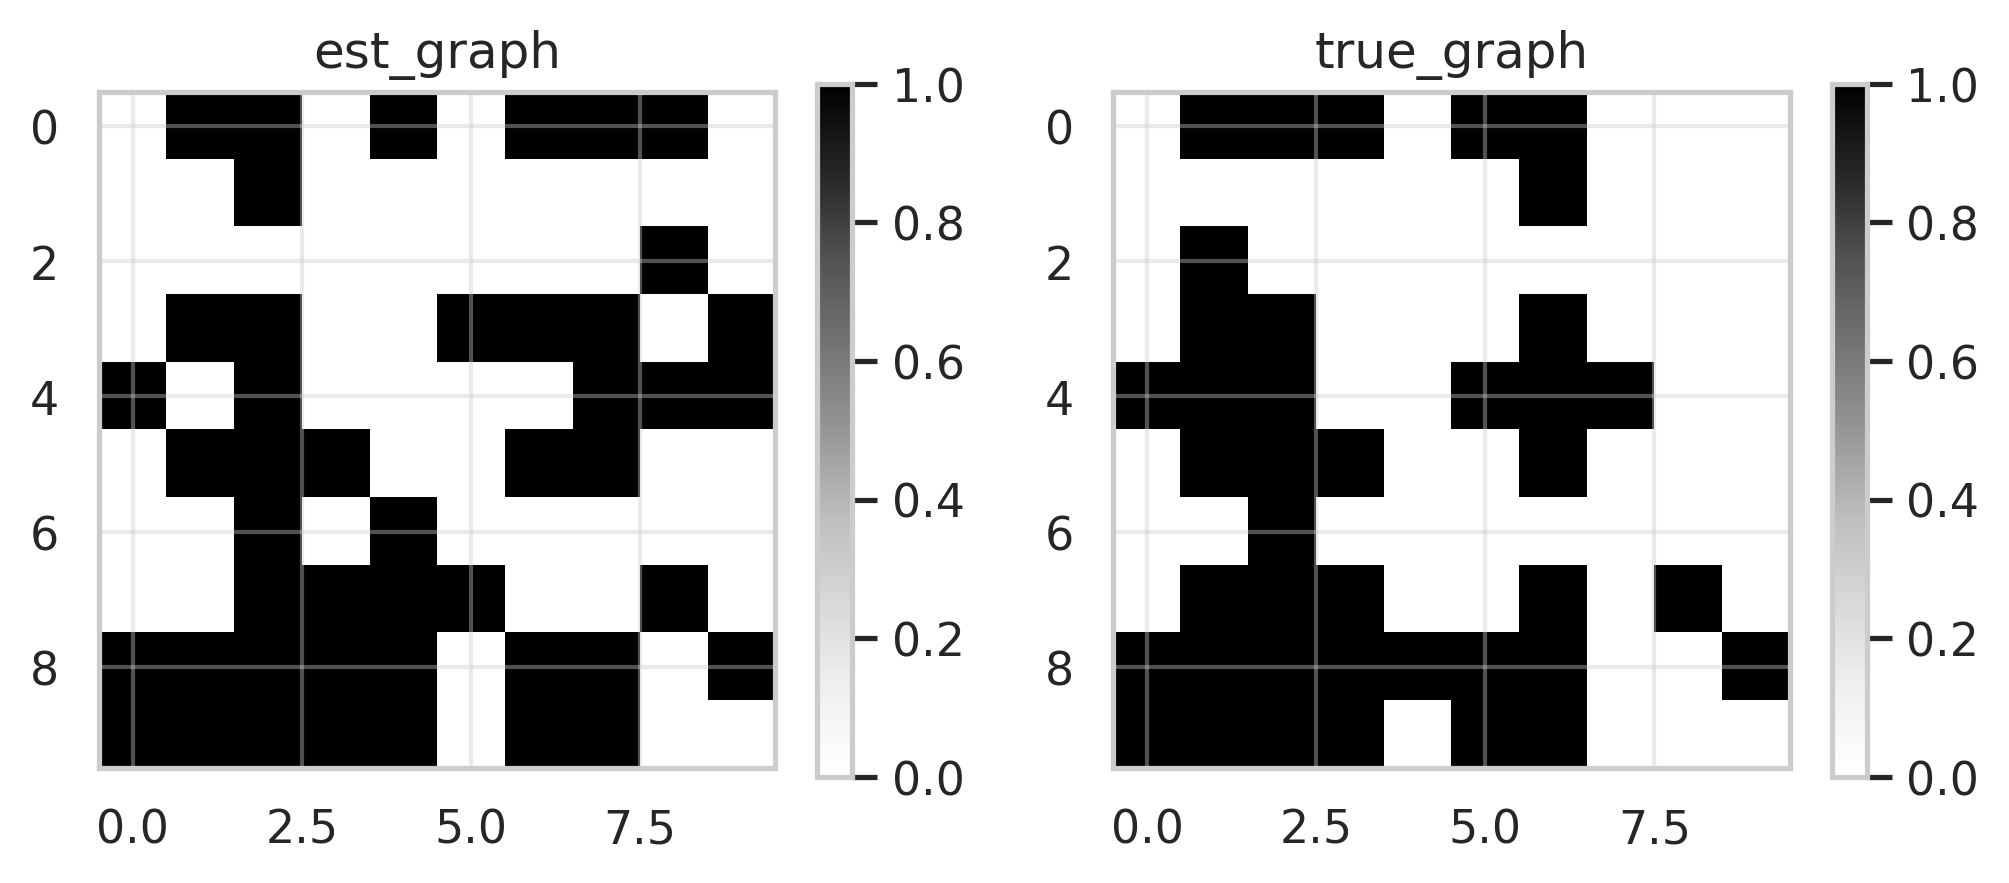

{'fdr': 0.1714, 'tpr': 0.725, 'fpr': 1.2, 'shd': 15, 'nnz': 35, 'precision': 0.6304, 'recall': 0.725, 'F1': 0.6744, 'gscore': 0.3}


In [20]:
# golem

gol = GOLEM(num_iter=20000, lambda_1=1e-5, lambda_2=0.0, non_equal_variances=False, device_type='gpu', no_dag_constraint=True) # we deactivate DAG constraint by setting lambda_2=0.0 as done in FRP paper
gol.learn(X)

# plot est_dag and true_dag
W_est_gol = np.array(gol.weight_causal_matrix)
B_est_gol = np.array(gol.causal_matrix)
GraphDAG(B_est_gol, B_true)

# calculate accuracy
met_gol = MetricsDAG(B_est_gol, B_true)
print(met_gol.metrics)

Number of absolute values in W_est larger than 0.1: 73
Number of absolute values in W_est larger than 0.2: 47
Number of absolute values in W_est larger than 0.3: 32
Number of edges in B_est: 32


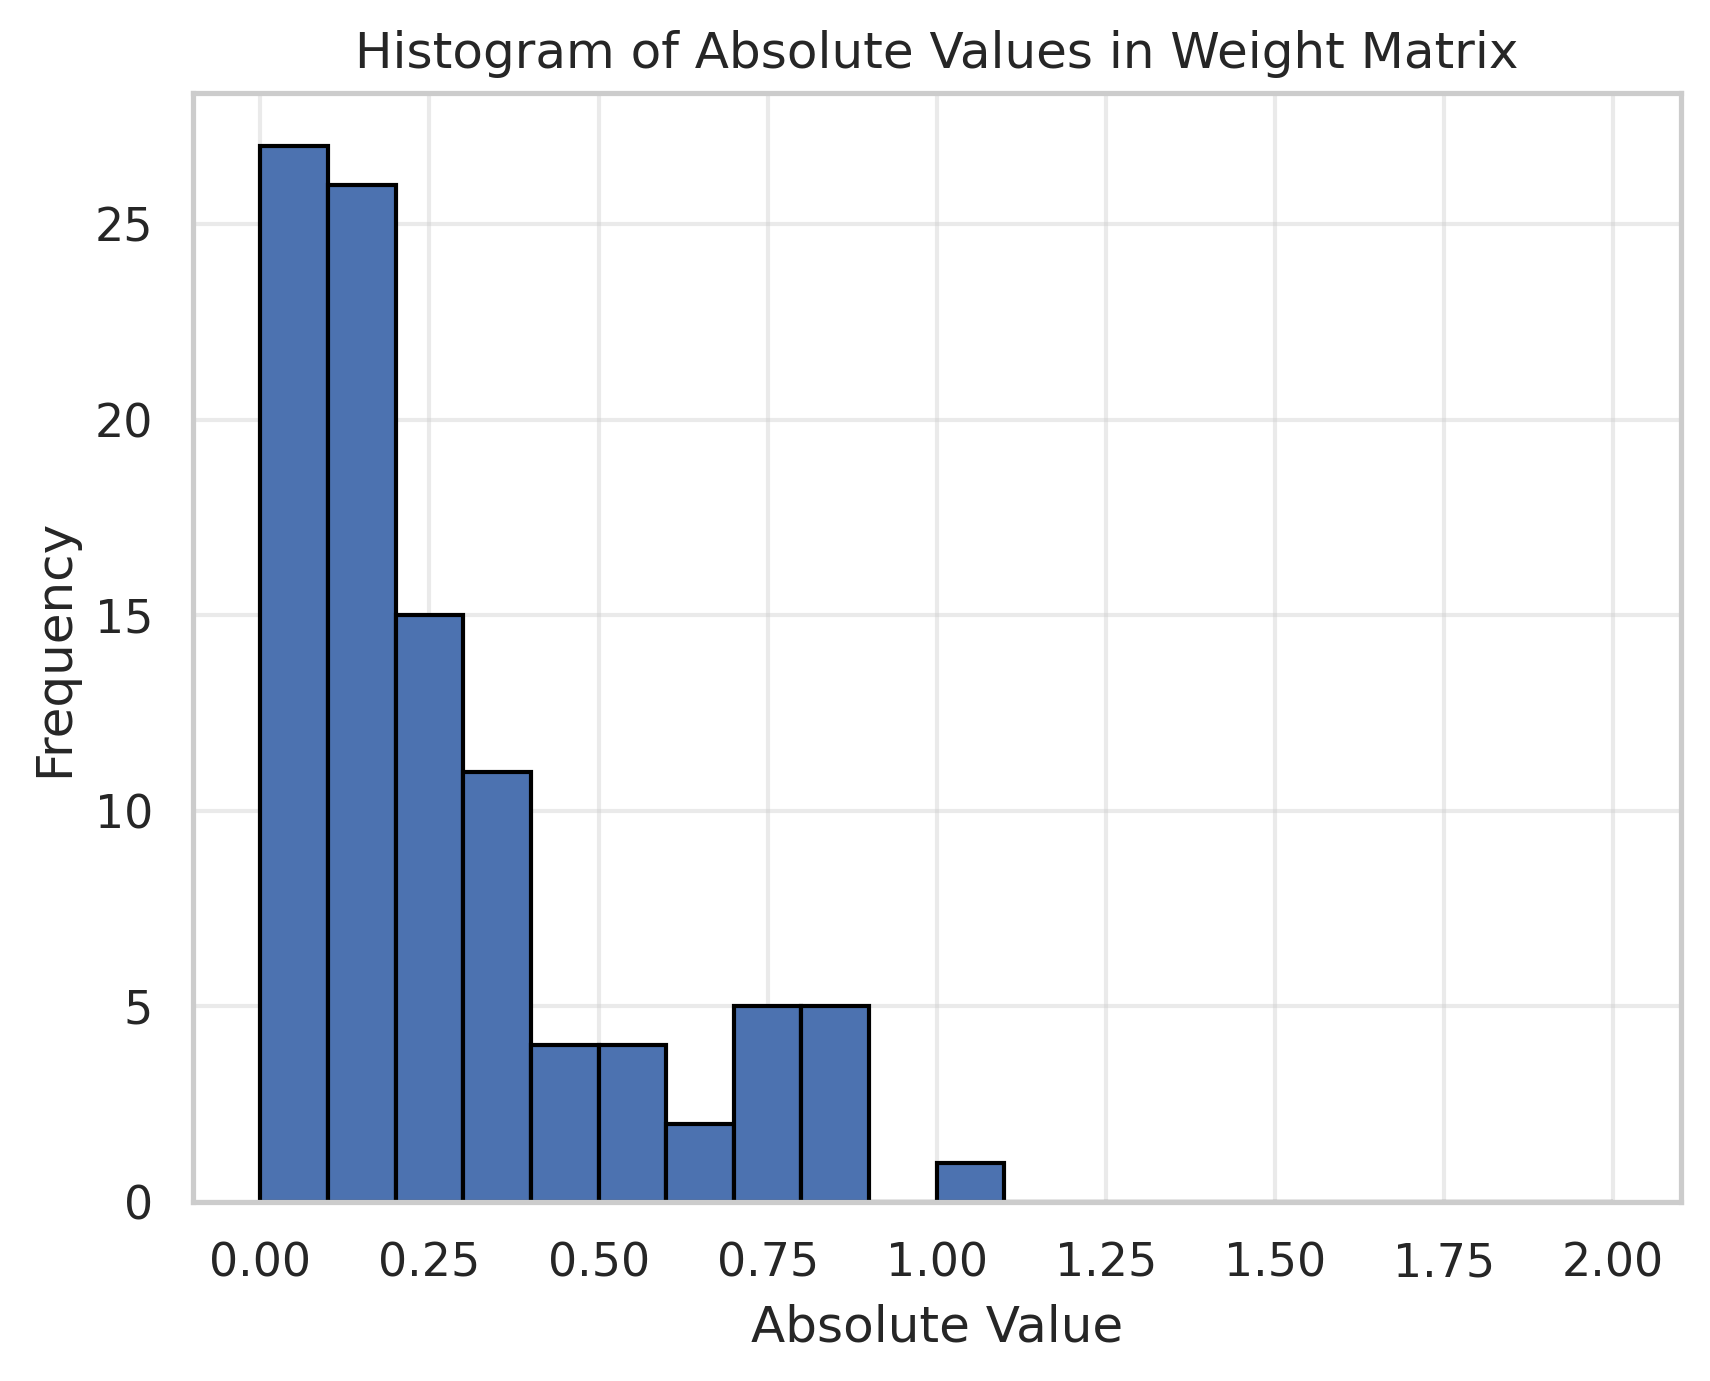

In [187]:
# analyse our model
counts, num_edges = analyze_weight_thresholds(W_est, B_est, threshold_values=[0.1, 0.2, 0.3])
plot_weights_distribution(W_est)

In [210]:
# TODO: update metrics for newly added models, then create a utility function to print the metrics of all models

# Show metrics of all models (ours, LiNG, dglearn, FRP, Notears, GOLEM, NODAGS)

# use the function compute_model_fit to get the BIC and AIC scores for our method
# NOTE: in theory compute_model_fit expects W and X as arguments, for the models that do not return W, we can use the B_est and X as arguments
bic_our, aic_our = compute_model_fit(W_est, X)
bic_ling, aic_ling = compute_model_fit(W_ling, X)
bic_dglearn, aic_dglearn = compute_model_fit(B_est_dglearn, X) # does not return W, only learns B
bic_frp, aic_frp = compute_model_fit(B_est_frp, X) # does not return W, only learns B
bic_nt, aic_nt = compute_model_fit(W_est_nt, X)
bic_gol, aic_gol = compute_model_fit(W_est_gol, X)
bic_nodags, aic_nodags = compute_model_fit(W_est_nodags, X)

print(f"BIC and AIC scores for our method: {bic_our:.3f}, {aic_our:.3f}")
print(f"BIC and AIC scores for LinG method: {bic_ling:.3f}, {aic_ling:.3f}")
print(f"BIC and AIC scores for dglearn method: {bic_dglearn:.3f}, {aic_dglearn:.3f}")
print(f"BIC and AIC scores for FRP method: {bic_frp:.3f}, {aic_frp:.3f}")
print(f"BIC and AIC scores for Notears method: {bic_nt:.3f}, {aic_nt:.3f}")
print(f"BIC and AIC scores for GOLEM method: {bic_gol:.3f}, {aic_gol:.3f}")
print(f"BIC and AIC scores for NODAGS method: {bic_nodags:.3f}, {aic_nodags:.3f}")

# Compute SHD and cycle F1 for all methods
cycle_shd_our = compute_cycle_SHD(B_true_EC, B_est) # Our method
cycle_shd_ling = compute_cycle_SHD(B_true_EC, B_est_ling)  # LinG method
cycle_shd_dglearn = compute_cycle_SHD(B_true_EC, B_est_dglearn)  # dglearn method
cycle_shd_frp = compute_cycle_SHD(B_true_EC, B_est_frp)  # FRP method
cycle_shd_nt = compute_cycle_SHD(B_true_EC, B_est_nt)  # Notears method
cycle_shd_gol = compute_cycle_SHD(B_true_EC, B_est_gol)  # GOLEM method
cycle_shd_nodags = compute_cycle_SHD(B_true_EC, B_est_nodags)  # NODAGS method

# B or B.T can be used for cycle F1, it doesn't matter
cycle_f1_our = compute_cycle_F1(B_true, B_est)
cycle_f1_ling = compute_cycle_F1(B_true, B_est_ling)
cycle_f1_dglearn = compute_cycle_F1(B_true, B_est_dglearn)
cycle_f1_frp = compute_cycle_F1(B_true, B_est_frp)
cycle_f1_nt = compute_cycle_F1(B_true, B_est_nt)
cycle_f1_gol = compute_cycle_F1(B_true, B_est_gol)
cycle_f1_nodags = compute_cycle_F1(B_true, B_est_nodags)

# Print SHD and cycle F1 scores
print(f"SHD cyclic and cycle F1 using our method: {cycle_shd_our}, {cycle_f1_our}")
print(f"SHD cyclic and cycle F1 using LinG method: {cycle_shd_ling}, {cycle_f1_ling}")
print(f"SHD cyclic and cycle F1 using dglearn method: {cycle_shd_dglearn}, {cycle_f1_dglearn}")
print(f"SHD cyclic and cycle F1 using FRP method: {cycle_shd_frp}, {cycle_f1_frp}")
print(f"SHD cyclic and cycle F1 using Notears method: {cycle_shd_nt}, {cycle_f1_nt}")
print(f"SHD cyclic and cycle F1 using GOLEM method: {cycle_shd_gol}, {cycle_f1_gol}")
print(f"SHD cyclic and cycle F1 using NODAGS method: {cycle_shd_nodags}, {cycle_f1_nodags}")

# compute_CSS using compute_CSS(shd_cyclic, cycle_f1, epsilon=1e-8)
css_our = compute_CSS(cycle_shd_our, cycle_f1_our, epsilon=1e-8)
css_ling = compute_CSS(cycle_shd_ling, cycle_f1_ling, epsilon=1e-8)
css_dglearn = compute_CSS(cycle_shd_dglearn, cycle_f1_dglearn, epsilon=1e-8)
css_frp = compute_CSS(cycle_shd_frp, cycle_f1_frp, epsilon=1e-8)
css_nt = compute_CSS(cycle_shd_nt, cycle_f1_nt, epsilon=1e-8)
css_gol = compute_CSS(cycle_shd_gol, cycle_f1_gol, epsilon=1e-8)
css_nodags = compute_CSS(cycle_shd_nodags, cycle_f1_nodags, epsilon=1e-8)

# compute cycle KLD using compute_cycle_KLD
cycle_kld_our = compute_cycle_KLD(prec_matrix, B_est)
cycle_kld_ling = compute_cycle_KLD(prec_matrix, B_est_ling)
cycle_kld_dglearn = compute_cycle_KLD(prec_matrix, B_est_dglearn)
cycle_kld_frp = compute_cycle_KLD(prec_matrix, B_est_frp)
cycle_kld_nt = compute_cycle_KLD(prec_matrix, B_est_nt)
cycle_kld_gol = compute_cycle_KLD(prec_matrix, B_est_gol)
cycle_kld_nodags = compute_cycle_KLD(prec_matrix, B_est_nodags)

# print the cycle KLD scores and CSS scores
print(f"Cycle KLD and CSS using our method: {cycle_kld_our}, {css_our}")
print(f"Cycle KLD and CSS using LinG method: {cycle_kld_ling}, {css_ling}")
print(f"Cycle KLD and CSS using dglearn method: {cycle_kld_dglearn}, {css_dglearn}")
print(f"Cycle KLD and CSS using FRP method: {cycle_kld_frp}, {css_frp}")
print(f"Cycle KLD and CSS using Notears method: {cycle_kld_nt}, {css_nt}")
print(f"Cycle KLD and CSS using GOLEM method: {cycle_kld_gol}, {css_gol}")
print(f"Cycle KLD and CSS using NODAGS method: {cycle_kld_nodags}, {css_nodags}")

2025-02-06 19:29:31,238 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/semopy/solver.py[line:103] - WARNING: Solver didnt converge, see SolverResult.


BIC and AIC scores for our method: 8.045, -57.127
BIC and AIC scores for LinG method: 39.526, -25.646
BIC and AIC scores for dglearn method: 34.527, -30.645
BIC and AIC scores for FRP method: -inf, -inf
BIC and AIC scores for Notears method: 1.803, -63.369
BIC and AIC scores for GOLEM method: 39.726, -25.446
BIC and AIC scores for NODAGS method: 47.277, -17.894
SHD cyclic and cycle F1 using our method: 20, 0.25
SHD cyclic and cycle F1 using LinG method: 30, 0.20833333333333331
SHD cyclic and cycle F1 using dglearn method: 31, 0.0
SHD cyclic and cycle F1 using FRP method: 25, 0.1875
SHD cyclic and cycle F1 using Notears method: 30, 0.24242424242424243
SHD cyclic and cycle F1 using GOLEM method: 25, 0.2439024390243902
SHD cyclic and cycle F1 using NODAGS method: 37, 0.14285714285714285
Cycle KLD and CSS using our method: 0.3084725913556783, 83.99999664000013
Cycle KLD and CSS using LinG method: 9.923919375154355e-08, 148.79999285760036
Cycle KLD and CSS using dglearn method: 0.0017901397

In [211]:
import numpy as np

def estimate_weighted_adjacency(X, B_learned):
    """Estimate W while enforcing the structure from B_learned."""
    d = X.shape[1]
    W_est = np.zeros((d, d))

    for j in range(d):
        parents = np.where(B_learned[:, j] == 1)[0]
        if len(parents) > 0:
            W_est[parents, j], _, _, _ = np.linalg.lstsq(X[:, parents], X[:, j], rcond=None)

    np.fill_diagonal(W_est, 0)  # Remove self-loops
    W_est /= np.linalg.norm(W_est, axis=0, ord=2, keepdims=True) + 1e-6  # Normalize columns
    return W_est


def kl_divergence(X, predicted_X):
    """Compute KL divergence between X and predicted_X."""
    d = X.shape[1]
    
    cov_X = np.cov(X, rowvar=False) + np.eye(d) * 1e-3
    cov_pred = np.cov(predicted_X, rowvar=False) + np.eye(d) * 1e-3

    eigvals_X, eigvecs_X = np.linalg.eigh(cov_X)
    eigvals_pred, eigvecs_pred = np.linalg.eigh(cov_pred)

    eigvals_X = np.clip(eigvals_X, 1e-6, None)
    eigvals_pred = np.clip(eigvals_pred, 1e-6, None)

    sqrt_cov_X = eigvecs_X @ np.diag(np.sqrt(eigvals_X)) @ eigvecs_X.T
    sqrt_cov_pred = eigvecs_pred @ np.diag(np.sqrt(eigvals_pred)) @ eigvecs_pred.T

    predicted_X = predicted_X @ np.linalg.inv(sqrt_cov_pred) @ sqrt_cov_X

    try:
        inv_cov_pred = np.linalg.inv(cov_pred)
    except np.linalg.LinAlgError:
        return np.inf

    trace_term = np.trace(inv_cov_pred @ cov_X)
    mean_diff = np.mean(predicted_X, axis=0) - np.mean(X, axis=0)
    quadratic_term = mean_diff.T @ inv_cov_pred @ mean_diff

    log_det_term = np.sum(np.log(np.maximum(eigvals_pred, 1e-12))) - np.sum(np.log(np.maximum(eigvals_X, 1e-12)))

    kl = 0.5 * (trace_term + quadratic_term - d + log_det_term)
    return np.maximum(kl, 1e-12)


def js_divergence(X, predicted_X):
    """Compute the JS divergence between X and predicted_X."""
    M = 0.5 * (X + predicted_X)
    return 0.5 * (kl_divergence(X, M) + kl_divergence(predicted_X, M))


def compute_cyclic_fit_metrics(X, B_learned, noise_std=1.0):
    """Compute Log-Likelihood and KL Divergence"""
    d = X.shape[1]
    I = np.eye(d)

    try:
        W_est = estimate_weighted_adjacency(X, B_learned)

        noise_est = ((I - W_est) @ X.T).T  # Solve for noise ε
        log_p = -0.5 * np.sum((noise_est / noise_std) ** 2) - (X.shape[0] * d / 2) * np.log(2 * np.pi * noise_std ** 2)
        log_p = np.maximum(log_p, -1e12)

        kl_div = kl_divergence(X, (W_est @ X.T).T)

        return log_p.item(), kl_div

    except np.linalg.LinAlgError:
        return -1e12, np.inf        

# apply the above function compute_cyclic_fit_metrics to all methods' B_est and print the log-likelihood and KL divergence
log_likelihood_our, kl_div_our = compute_cyclic_fit_metrics(X, B_est)
log_likelihood_ling, kl_div_ling = compute_cyclic_fit_metrics(X, B_est_ling)
log_likelihood_dglearn, kl_div_dglearn = compute_cyclic_fit_metrics(X, B_est_dglearn)
log_likelihood_frp, kl_div_frp = compute_cyclic_fit_metrics(X, B_est_frp)
log_likelihood_nt, kl_div_nt = compute_cyclic_fit_metrics(X, B_est_nt)
log_likelihood_gol, kl_div_gol = compute_cyclic_fit_metrics(X, B_est_gol)
log_likelihood_nodags, kl_div_nodags = compute_cyclic_fit_metrics(X, B_est_nodags)

print(f"Log-likelihood, KL divergence using our method: {log_likelihood_our:.3f}, {kl_div_our:.3f}")
print(f"Log-likelihood, KL divergence using LinG method: {log_likelihood_ling:.3f}, {kl_div_ling:.3f}")
print(f"Log-likelihood, KL divergence using dglearn method: {log_likelihood_dglearn:.3f}, {kl_div_dglearn:.3f}")
print(f"Log-likelihood, KL divergence using FRP method: {log_likelihood_frp:.3f}, {kl_div_frp:.3f}")
print(f"Log-likelihood, KL divergence using Notears method: {log_likelihood_nt:.3f}, {kl_div_nt:.3f}")
print(f"Log-likelihood, KL divergence using GOLEM method: {log_likelihood_gol:.3f}, {kl_div_gol:.3f}")
print(f"Log-likelihood, KL divergence using NODAGS method: {log_likelihood_nodags:.3f}, {kl_div_nodags:.3f}")

Log-likelihood, KL divergence using our method: -219648.634, 6117.791
Log-likelihood, KL divergence using LinG method: -127790.112, 623.644
Log-likelihood, KL divergence using dglearn method: -119944.905, 1045.817
Log-likelihood, KL divergence using FRP method: -155363.564, 2357.443
Log-likelihood, KL divergence using Notears method: -147310.334, 1125.543
Log-likelihood, KL divergence using GOLEM method: -217161.940, 4343.317
Log-likelihood, KL divergence using NODAGS method: -161750.327, 4939.024


In [177]:
################################################ MISC NON CYCLIC MODELS ################################################

In [ ]:
import semopy
is_ordinal = np.array([0 if len(np.unique(X[:, col])) > 2 else 1 for col in range(X.shape[1])]).tolist() # 0 for continuous, 1 for ordinal

# build desc
desc = ""
eta_names = []

for i, row in enumerate(B_est_frp):
    # exogenous
    if np.sum(np.isnan(row)) == 0 and np.sum(np.isclose(row, 0)) == row.shape[0]:
        continue

    desc += f"x{i:d} ~ "

    for j, elem in enumerate(row):
        if np.isnan(elem):
            eta_name = f"eta_{i}_{j}" if i < j else f"eta_{j}_{i}"
            desc += f"{eta_name} + "
            if eta_name not in eta_names:
                eta_names.append(eta_name)
        elif not np.isclose(elem, 0):
            desc += f"{elem:f} * x{j:d} + "
    desc = desc[: -len(" * ")] + "\n"

if len(eta_names) > 0:
    desc += "DEFINE(latent) " + " ".join(eta_names) + "\n"

if sum(is_ordinal) > 0:
    indices = np.argwhere(is_ordinal).flatten()

    desc += "DEFINE(ordinal)"
    for i in indices:
        desc += f" x{i}"
    desc += "\n"

columns = [f"x{i:d}" for i in range(X.shape[1])]
_X = pd.DataFrame(X, columns=columns)

m = semopy.Model(desc)
m.fit(_X)
stats = semopy.calc_stats(m)
display(stats)

In [ ]:
B_temp = B_est # rank 9 and zero determinant
# B_temp = B_est_ling # full rank and non-zero determinant
# B_temp = B_est_dglearn # rank 8 and zero determinant
# B_temp = B_est_frp # full rank and non-zero determinant
# B_temp = B_est_nt # rank 9 and non-zero determinant
# B_temp = B_est_gol # rank 7 and zero determinant
# B_temp = B_est_nodags # full rank and non-zero determinant

# Assuming B_temp is already defined
print("Shape of B_temp:", B_temp.shape)
print("Data type of B_temp:", B_temp.dtype)

# Convert B_temp to a numerical matrix
B_temp_numeric = B_temp.astype(float)

det = np.linalg.det(B_temp_numeric)
print("Determinant of B_temp:", det)

rank = np.linalg.matrix_rank(B_temp_numeric)
print("Rank of B_temp:", rank)

cond_num = np.linalg.cond(B_temp_numeric)
print("Condition number of B_temp:", cond_num)

In [71]:
def compute_KLD(B_true, B_est):
    """
        Computes the KL-Divergence between two multivariate normal
        distributions with given precision matrices,
        assuming that they are both zero mean
    """

    # Compute the precision matrices
    def precision_matrix_simplified(B):
        """
        Given a B matrix, compute precision matrix assuming equal variances.
        """
        dim = B.shape[0]
        Q = np.eye(dim) - B
        return Q @ Q.T  # Ignoring logvars factor since variances are constant in equal variances setup

    prec_true = precision_matrix_simplified(B_true)
    prec_est = precision_matrix_simplified(B_est)

    assert np.all(prec_true.shape == prec_est.shape)
    assert prec_true.shape[0] == prec_true.shape[1]
    dim = prec_true.shape[0]

    (sign1, logdet1) = np.linalg.slogdet(prec_true)
    (sign2, logdet2) = np.linalg.slogdet(prec_est)

    return 0.5*(sign1*logdet1 - sign2*logdet2 - dim + np.trace(prec_est@np.linalg.inv(prec_true)))


# compute KLD for all methods
kld_our = compute_KLD(B_true, B_est)
kld_ling = compute_KLD(B_true, B_est_ling)
kld_dglearn = compute_KLD(B_true, B_est_dglearn)
kld_frp = compute_KLD(B_true, B_est_frp)
kld_nt = compute_KLD(B_true, B_est_nt)
kld_gol = compute_KLD(B_true, B_est_gol)
kld_nodags = compute_KLD(B_true, B_est_nodags)

# print the KLD scores
print(f"KLD using our method: {kld_our}")
print(f"KLD using LinG method: {kld_ling}")
print(f"KLD using dglearn method: {kld_dglearn}")
print(f"KLD using FRP method: {kld_frp}")
print(f"KLD using Notears method: {kld_nt}")
print(f"KLD using GOLEM method: {kld_gol}")
print(f"KLD using NODAGS method: {kld_nodags}")

In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import GOLEM

# GOLEM learn
#gol = GOLEM(num_iter=2e4, lambda_2=1e4/X.shape[1], lambda_1=1e-2)
#gol = GOLEM(num_iter=2e4, lambda_2=0.0)  setting h_reg to 0 still allows model to be fit (no error thrown)
gol = GOLEM(num_iter=2e4, non_equal_variances=True, lambda_1=1e-2) # F1 of 60%
#g = GOLEM(num_iter=2e4, non_equal_variances=False) # F1 of 68%, default non_equal_variances=True
gol.learn(X)

# plot est_dag and true_dag
GraphDAG(gol.causal_matrix, B_true)

# calculate accuracy
gol_met = MetricsDAG(gol.causal_matrix, B_true)
print(gol_met.metrics)
print("The number of edges in golem graph: ", np.sum(gol.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import Notears

# notears learn
nt = Notears(lambda1=1e-3, h_tol=1e-5, max_iter=100) # default loss_type is 'l2', F1 of 27%
#nt = Notears(lambda1=1e-2, h_tol=1e-5, max_iter=10000, loss_type='logistic')
#nt = Notears(lambda1=1e-2, h_tol=1e-5, max_iter=10000, loss_type='poisson')
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, B_true)

# calculate accuracy
nt_met = MetricsDAG(nt.causal_matrix, B_true)
print(nt_met.metrics)
print("The number of edges in notears graph: ", np.sum(nt.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import PC

# A variant of PC-algorithm, one of [`original`, `stable`, `parallel`]
pc = PC(variant='parallel', alpha=0.05, ci_test='fisherz') # F1 of 15%
#pc = PC(variant='stable', alpha=0.05) # F1 of 17%
#pc = PC(variant='original', alpha=0.05) # F1 of 19%
pc.learn(X)

# plot est_dag and true_dag
GraphDAG(pc.causal_matrix, B_true)

# calculate accuracy
pc_met = MetricsDAG(pc.causal_matrix, B_true)
print(pc_met.metrics)
print("The number of edges in pc graph: ", np.sum(pc.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms.ges.ges import GES

# GES learn
# method is one of ['r2', 'scatter']
ges = GES() # F1 of 42%
#ges = GES(criterion='bic', method='scatter') # F1 of 47%
#ges = GES(criterion='bic', method='r2') # F1 of 4%

# learn the graph structure
# create X_ges that adds noise to X because GES complains about singular matrix
X_ges = X + np.random.normal(0, 1, X.shape)**4
ges.learn(X)

# plot est_dag and true_dag
GraphDAG(ges.causal_matrix, B_true)

# calculate accuracy
ges_met = MetricsDAG(ges.causal_matrix, B_true)
print(ges_met.metrics)
print("The number of edges in ges graph: ", np.sum(ges.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import DirectLiNGAM

# measure : {'pwling', 'kernel'}, default='pwling'
g_ling = DirectLiNGAM(measure='pwling') # F1 of 74%
#g = DirectLiNGAM(measure='kernel') # F1 of nan - takes too long to run (even after 15 minutes not done)
g_ling.learn(X)

# plot est_dag and true_dag
GraphDAG(g_ling.causal_matrix, B_true)

# calculate accuracy
g_ling_met = MetricsDAG(g_ling.causal_matrix, B_true)
print(g_ling_met.metrics)
print("The number of edges in directlingam graph: ", np.sum(g_ling.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import ICALiNGAM

# ICALiNGAM learn
# max_iter : int, optional (default=1000)
#g = ICALiNGAM(max_iter=1000) # F1 of 48%
g_ica = ICALiNGAM(max_iter=1000) # F1 of 51%
g_ica.learn(X)

# plot est_dag and true_dag
ica_W_est = g_ica.weight_causal_matrix
ica_B_est = g_ica.causal_matrix
GraphDAG(ica_B_est, B_true)

# calculate accuracy
met_ica = MetricsDAG(ica_B_est, B_true)
print(met_ica.metrics)

In [ ]:
# print compute_cycle_SHD and compute_cycle_F1 for all methods, usage: compute_cycle_F1(B_true, B_est), directly print both with method name in single line
shd_our = compute_cycle_SHD(B_true_EC, B_est) # our method
shd_gol = compute_cycle_SHD(B_true_EC, gol.causal_matrix) # golem
shd_nt = compute_cycle_SHD(B_true_EC, nt.causal_matrix) # notears
shd_icag = compute_cycle_SHD(B_true_EC, g_ica.causal_matrix) # icalingam
shd_ling = compute_cycle_SHD(B_true_EC, g_ling.causal_matrix) # lingam

cycle_f1_our = compute_cycle_F1(B_true, B_est, verbose=True)
cycle_f1_gol = compute_cycle_F1(B_true, gol.causal_matrix, verbose=True)
cycle_f1_nt = compute_cycle_F1(B_true, nt.causal_matrix, verbose=True)
cycle_f1_icag = compute_cycle_F1(B_true, g_ica.causal_matrix, verbose=True)
cycle_f1_ling = compute_cycle_F1(B_true, g_ling.causal_matrix, verbose=True)

print(f"SHD cyclic and cycle F1 using our method: {shd_our}, {cycle_f1_our}")
print(f"SHD cyclic and cycle F1 using golem: {shd_gol}, {cycle_f1_gol}")
print(f"SHD cyclic and cycle F1 using notears: {shd_nt}, {cycle_f1_nt}")
print(f"SHD cyclic and cycle F1 using icalingam: {shd_icag}, {cycle_f1_icag}")
print(f"SHD cyclic and cycle F1 using lingam: {shd_ling}, {cycle_f1_ling}")

In [ ]:
from dglearn import *

# learn structure using tabu search, plot learned structure
tabu_length = X.shape[1] # number of variables
patience = 5

manager = CyclicManager(X, bic_coef=0.5)
learned_support, best_score, log = tabu_search(manager, tabu_length, patience, first_ascent=False, verbose=1) # returns a binary matrix as learned support
# the above does not finish running (within 2 hours) for a graph with 15 nodes and 4000 samples # need to run overnight

In [ ]:
# perform virtual edge correction
print("virtual edge correction...")
learned_support = virtual_refine(manager, learned_support, patience=0, max_path_len=6, verbose=1)

# remove any reducible edges
learned_support = reduce_support(learned_support, fill_diagonal=False)

In [ ]:
# plot est_dag and true_dag
GraphDAG(learned_support, B_true)

# calculate accuracy
dg_met = MetricsDAG(learned_support, B_true)
print(dg_met.metrics)

In [ ]:
print("Number of graphs in the equivalence class: %d" % len(B_true_EC))